# AIAP 22 Technical Assessment - Exploratory Data Analysis for Phishing Dataset 


## Table of Contents<a id='0'></a>

### [1. Introduction](#1)

- Problem Statement
- Data Description

### [2. Data Acquisition and Loading](#2)

- Notebook Setup
- Load Data


### [3. Data Cleaning and Processing](#3)

- Rename Columns and Convert Types
- Drop Duplicates
- Handling Unusual Values and Ranges
- Handling Null Values

### [4. Data Analysis and Visualisation](#4)
- Analyses of Impact of Categorical Variables on Activity Level
- Analyses of Impact of Numerical Variables on Activity Level

### [5. Conclusions](#5)
- Insights
- Next Steps
---

## 1. Introduction<a id='1'></a>
[Return to Table of Contents](#0)

### Problem Statement
 



### Data Description

---

## 2. Data Acquisition and Loading<a id='2'></a>
[Return to Table of Contents](#0)

### 2a. Notebook Setup

In [ ]:
# Load necessary packages for data ingestion, cleaning EDA 

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, ttest_ind, f_oneway
from sqlalchemy import create_engine, MetaData, inspect
import requests
from pathlib import Path
from pyampute.exploration.mcar_statistical_tests import MCARTest

# Set Pandas options

%matplotlib inline
plt.rcParams['figure.figsize'] = [25,10]
plt.rcParams['font.size'] = 24
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_rows', 120)

### 2b. Load Data

In [2]:

DATA_URL = "https://techassessment.blob.core.windows.net/aiap22-assessment-data/phishing.db"
DATA_DIR = Path("data")
DB_PATH = DATA_DIR / "phishing.db"

DATA_DIR.mkdir(parents=True, exist_ok=True)

def download_database(force_refresh=False):
    """Download the phishing SQLite DB unless a cached copy exists (or refresh requested)."""
    if DB_PATH.exists() and not force_refresh:
        print(f"Using cached database at {DB_PATH.resolve()}")
        return DB_PATH

    print("Downloading phishing.db ...")
    response = requests.get(DATA_URL, timeout=30)
    response.raise_for_status()
    DB_PATH.write_bytes(response.content)
    print(f"Saved database to {DB_PATH.resolve()}")
    return DB_PATH

db_path = download_database()
db_path


Using cached database at C:\Users\epist\OneDrive\Desktop\aiap-22-project\data\phishing.db


WindowsPath('data/phishing.db')

In [3]:
# Load dataset using Sqlalchemy

engine = create_engine('sqlite:///data/phishing.db')
conn = engine.connect()

# Reflect data
metadata = MetaData()
metadata.reflect(bind=engine)

# Check what tables exist
insp = inspect(engine)
tables = insp.get_table_names()
print('\033[1m'+ "Tables in DB: " + '\033[0m', tables) 


Tables in DB:  ['phishing_data']


In [4]:
# Convert table(s) in db to pandas df:
df = pd.read_sql_table('phishing_data', con=engine)

### 2c. Basic Inspection

In [5]:
# Show first 5 rows of the dataframe for visual inspection

df.head()

,Unnamed: 0,LineOfCode,LargestLineLength,NoOfURLRedirect,NoOfSelfRedirect,NoOfPopup,NoOfiFrame,NoOfImage,NoOfSelfRef,NoOfExternalRef,Robots,IsResponsive,Industry,HostingProvider,DomainAgeMonths,label
0,0,NaN,9965,0,0,2,1,48,172,170,1,1,Fashion,DreamHost,98,0
1,1,769.00,9507,0,0,0,4,25,55,78,1,1,Fashion,AWS,31,1
2,2,720.00,2550,0,0,0,2,-31,94,13,0,1,Education,Google Cloud,26,1
3,3,198.00,869,0,0,0,0,0,0,2,0,0,Unknown,DreamHost,2,1
4,4,972.00,2807,0,0,0,2,6,83,51,0,1,Education,GoDaddy,43,1


In [6]:
# Print index, shape, data types

print('\033[1m'+ "Index: " + '\033[0m', df.index)
print('\033[1m' + "Number of rows: " + '\033[0m', df.shape[0])
print('\033[1m' + "Number of columns: " + '\033[0m', df.shape[1])
print('\033[1m' + "Data Types:" + '\033[0m\n' + str(df.dtypes))

Index:  RangeIndex(start=0, stop=10500, step=1)
Number of rows:  10500
Number of columns:  16
Data Types:
Unnamed: 0             int64
LineOfCode           float64
LargestLineLength      int64
NoOfURLRedirect        int64
NoOfSelfRedirect       int64
NoOfPopup              int64
NoOfiFrame             int64
NoOfImage              int64
NoOfSelfRef            int64
NoOfExternalRef        int64
Robots                 int64
IsResponsive           int64
Industry              object
HostingProvider       object
DomainAgeMonths        int64
label                  int64
dtype: object


In [7]:
# Check for null values

print('\033[1m' + "Total number of null values per column: "  + '\033[0m\n' + str(df.isnull().sum()))

# Check for number of unique values per column:

print('\033[1m' + "Total number of unique values per column: "  + '\033[0m\n' + str(df.nunique()))

Total number of null values per column: 
Unnamed: 0              0
LineOfCode           2355
LargestLineLength       0
NoOfURLRedirect         0
NoOfSelfRedirect        0
NoOfPopup               0
NoOfiFrame              0
NoOfImage               0
NoOfSelfRef             0
NoOfExternalRef         0
Robots                  0
IsResponsive            0
Industry                0
HostingProvider         0
DomainAgeMonths         0
label                   0
dtype: int64
Total number of unique values per column: 
Unnamed: 0           10500
LineOfCode            2875
LargestLineLength     4027
NoOfURLRedirect          2
NoOfSelfRedirect         2
NoOfPopup               26
NoOfiFrame              48
NoOfImage              308
NoOfSelfRef            533
NoOfExternalRef        463
Robots                   2
IsResponsive             2
Industry                11
HostingProvider         13
DomainAgeMonths        121
label                    2
dtype: int64


In [8]:
# List unique values for each categorical column (excluding one-hotted): 

for col in df.columns:
    if df[col].dtype == 'object':
        print('\033[1m' + "Unique Values of " + col + ": "  + '\033[0m\n' + str(df[col].unique()))


Unique Values of Industry: 
['Fashion' 'Education' 'Unknown' 'Manufacturing' 'eCommerce ' 'Non-profit'
 'Food' 'Government' 'eCommerce' 'Banking' 'Healthcare']
Unique Values of HostingProvider: 
['DreamHost' 'AWS' 'Google Cloud' 'GoDaddy' 'Freehostia' 'Bluehost'
 'Unknown Provider' 'Hostinger' 'Namecheap' 'InfinityFree' '000webhost'
 'Azure' 'HostGator']


In [9]:
# List summary statistics for each numerical column:

df.describe()

,Unnamed: 0,LineOfCode,LargestLineLength,NoOfURLRedirect,NoOfSelfRedirect,NoOfPopup,NoOfiFrame,NoOfImage,NoOfSelfRef,NoOfExternalRef,Robots,IsResponsive,DomainAgeMonths,label
count,10500.00,8145.00,10500.00,10500.00,10500.00,10500.00,10500.00,10500.00,10500.00,10500.00,10500.00,10500.00,10500.00,10500.00
mean,5249.50,1376.95,11197.96,0.14,0.04,0.23,1.67,325.27,68.54,51.15,0.26,0.62,33.17,0.55
std,3031.23,5751.56,94168.98,0.34,0.19,5.70,5.02,30896.86,316.68,204.90,0.44,0.48,32.70,0.50
min,0.00,2.00,22.00,0.00,0.00,0.00,0.00,-35.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,2624.75,88.00,180.75,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,5.00,0.00
50%,5249.50,620.00,1087.50,0.00,0.00,0.00,0.00,5.00,12.00,10.00,0.00,1.00,24.00,1.00
75%,7874.25,1452.00,8047.00,0.00,0.00,0.00,1.00,25.00,87.00,55.00,1.00,1.00,52.00,1.00
max,10499.00,418650.00,4336498.00,1.00,1.00,564.00,131.00,3166000.00,26596.00,12353.00,1.00,1.00,120.00,1.00


In [10]:
# Check for duplicate rows

df_dup = df[df.duplicated()]
df_dup.head()
print('\033[1m' + 'Total number of duplicated rows: ' + '\033[0m\n'  + str(len(df_dup)))


Total number of duplicated rows: 
0


In [11]:
# Categorize columns into categorical and numerical
# We categorize 'NoOfURLRedirect','NoOfSelfRedirect' as categoricals since they take binary values of either 1 or 0

cat_cols = ['NoOfURLRedirect','NoOfSelfRedirect', 'Robots', 'IsResponsive', 'Industry', 'HostingProvider', 'label']
num_cols = ['LineOfCode', 'LargestLineLength', 'NoOfPopup', 'NoOfiFrame', 'NoOfImage', 'NoOfSelfRef', 
            'NoOfExternalRef', 'DomainAgeMonths']

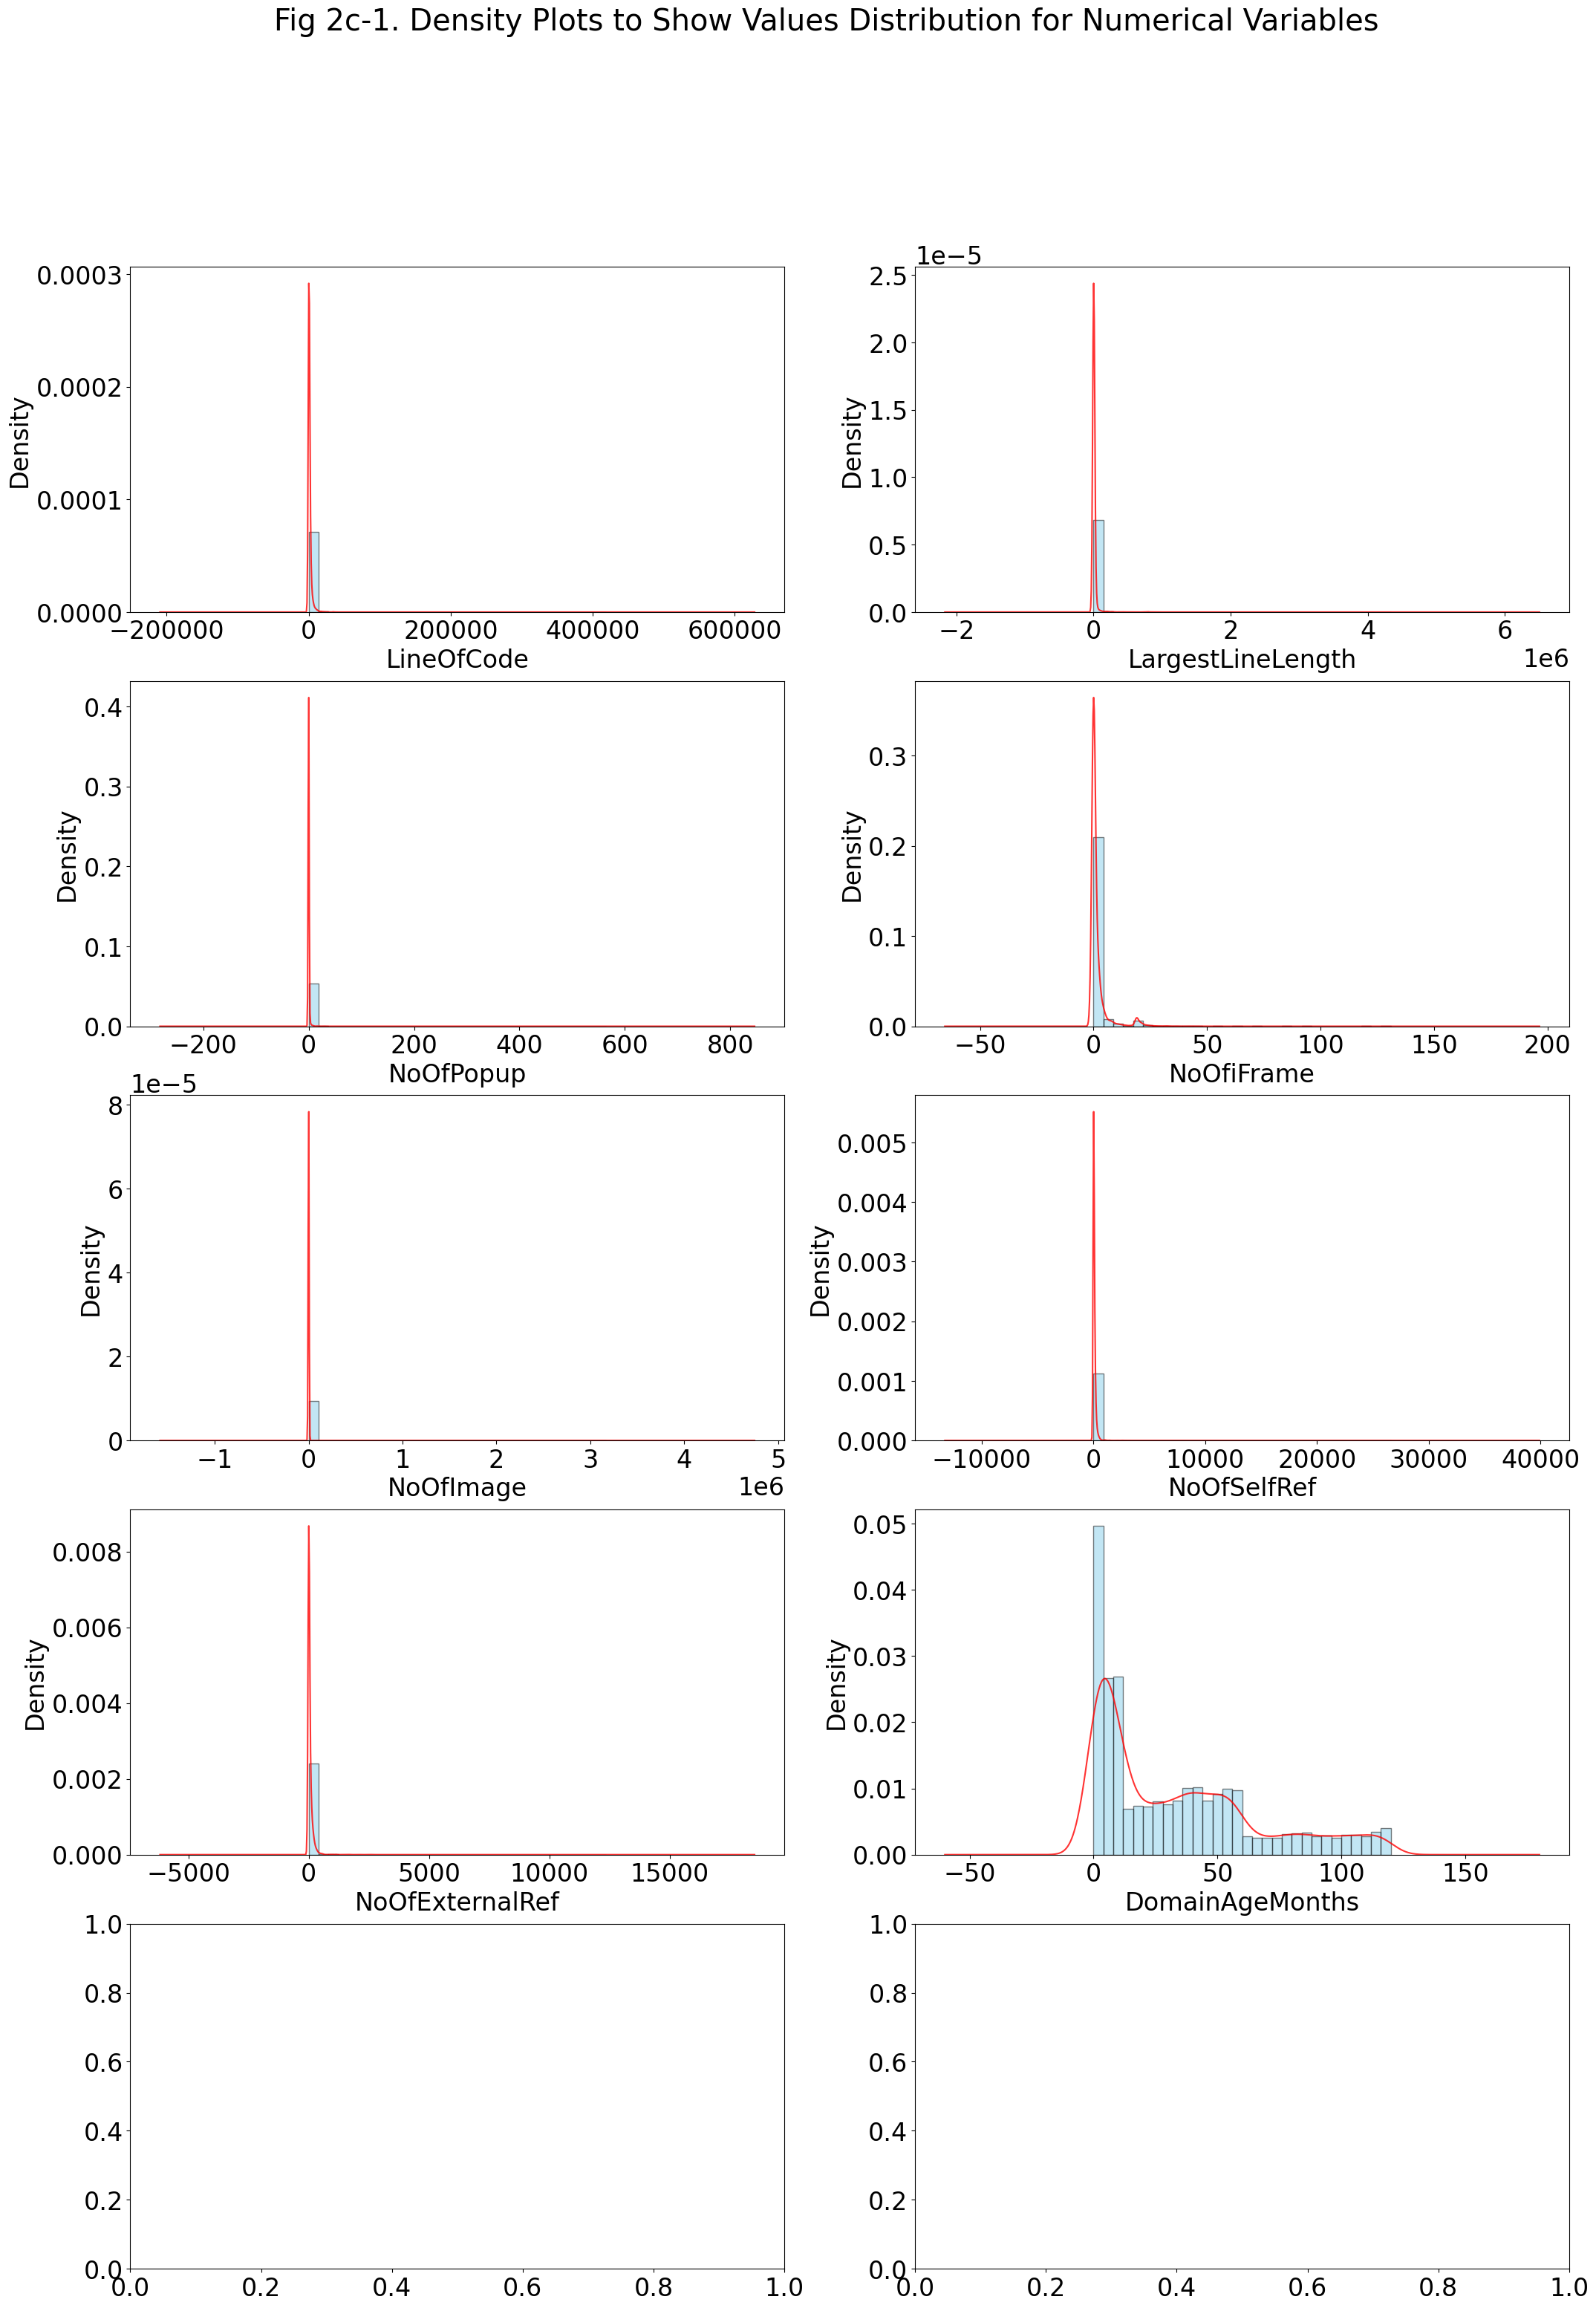

In [12]:
# Plot frequency distributions of each non-categorical continuous variable

plt.close('all') 

fig, axes = plt.subplots(5, 2, figsize=(25, 35))  # increase vertical figure size (height)
axes = axes.flatten()

# Plot histograms for each column
for i, col in enumerate(num_cols):
    df[col].plot(kind='hist', ax=axes[i], density=True, bins=30, alpha=0.5, color='skyblue', edgecolor='k')
    df[col].plot(kind='kde', ax=axes[i], alpha=0.8, color='red')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Density')

plt.suptitle("Fig 2c-1. Density Plots to Show Values Distribution for Numerical Variables")
plt.show()

Basic inspection of the above suggests the following data cleaning steps are needed for EDA:

1. **Address Null Values**. About 20% of **LineofCode** contains null values that need to be either imputed or eliminated.
2. **Address Outliers/Unusual Values**: Diagnose and address potential outlier/unusual values in **NoOfiFrame**, **NoOfPopup**, **NoOfImage**, **NoOfSelfRef**, **NoOfExternalRef**. In particular, the negative values in **NoOfImage**.
3. **Clean up categorical labels**: strip whitespace from values in categorical labels e.g. "eCommerce" in **Industry**

---  

## 3. Data Cleaning and Processing<a id='3'></a>
[Return to Table of Contents](#0)

### 3a. Addressing Null Values

**LineOfCode** has a significant number of null values (~20% of the dataset). Given the large proportion, there is a need to determine how to inpute suitable values. We do this by analysing if there is a pattern to the nullness of **LineOfCode** and various categorical features.

In [13]:
# Run pairwise significance tests to determine if there are meaningful patterns in the dropped data

# Create a missingness indicator for LineOfCode
df["LineOfCodeIsMissing"] = df["LineOfCode"].isnull().astype(int)

print('\033[1m\n' + "Missingness Analysis for Categorical Data" + '\033[0m\n')

for j in cat_cols:
    # Cross-tabulate missingness of LineOfCode against the values of categorical column j
    contingency_table = pd.crosstab(df["LineOfCodeIsMissing"], df[j])

    try:
        chi2, p, _, _ = chi2_contingency(contingency_table)

        if p < 0.05:
            print(f"Missingness in LineOfCode is related to '{j}' based on p=value of {p} → Not MCAR")
        else:
            print(f"No relationship detected between missingness in LineOfCode and '{j}' → Possibly MCAR")
    except ValueError:
        print(f"Chi-square test failed for LineOfCode and '{j}' (possibly due to sparse data).")

print('\033[1m\n' + "Missingness Analysis for Numeric Data" + '\033[0m\n')

for j in num_cols:
    if j != "LineOfCode":
        group0 = df[df["LineOfCodeIsMissing"] == 0][j].dropna()
        group1 = df[df["LineOfCodeIsMissing"] == 1][j].dropna()

        # Ensure both groups have enough data
        if len(group0) > 1 and len(group1) > 1:
            stat, p = ttest_ind(group0, group1, equal_var=False)  # Welch's t-test
            if p < 0.05:
                print(f"Missingness in LineOfCode is related to '{j}' based on p=value of {p} → Not MCAR")
            else:
                print(f"No relationship detected between missingness in LineOfCode and '{j}'  → Possibly MCAR")
        
        else:
            print(f"Chi-square test failed for LineOfCode and '{j}' (possibly due to sparse data).")



Missingness Analysis for Categorical Data

No relationship detected between missingness in LineOfCode and 'NoOfURLRedirect' → Possibly MCAR
No relationship detected between missingness in LineOfCode and 'NoOfSelfRedirect' → Possibly MCAR
Missingness in LineOfCode is related to 'Robots' based on p=value of 2.731032635061394e-48 → Not MCAR
Missingness in LineOfCode is related to 'IsResponsive' based on p=value of 2.325464769941828e-99 → Not MCAR
Missingness in LineOfCode is related to 'Industry' based on p=value of 4.455411372603803e-33 → Not MCAR
Missingness in LineOfCode is related to 'HostingProvider' based on p=value of 5.58165205430259e-130 → Not MCAR
Missingness in LineOfCode is related to 'label' based on p=value of 0.0 → Not MCAR

Missingness Analysis for Numeric Data

No relationship detected between missingness in LineOfCode and 'LargestLineLength'  → Possibly MCAR
Missingness in LineOfCode is related to 'NoOfPopup' based on p=value of 0.007758915573728946 → Not MCAR
Missingne

In [14]:
# Impact of missingness on label

print("\033[1mMean label by LineOfCode missingness:\033[0m")
mean_label_by_missingness = df.groupby(df["LineOfCode"].isnull())["label"].mean()
print(mean_label_by_missingness)


Mean label by LineOfCode missingness:
LineOfCode
False   0.71
True    0.00
Name: label, dtype: float64


Given that the various MCAR pairwise tests indicated that missingness was not random, and that the impact of missingness on the label is quite stark, we should not drop the column at this stage. Instead, we will include a flag to indicate the missingness in LineOfCode and impute 0 to the missing values for EDA purposes (since 0 is an unobserved for valid radings of LineOfCode). However, for the actual model, we will impute medians.

In [ ]:
# Create missingness flag and fill LineofCode nans with 0

df["LineOfCodeIsMissing"] = np.where(df.LineOfCode.isna(), 1, 0)
df.LineOfCode = df.LineOfCode.fillna(0) # ONLY for EDA; median during FE

In [16]:
# Check no nulls

df.isna().sum()

Unnamed: 0             0
LineOfCode             0
LargestLineLength      0
NoOfURLRedirect        0
NoOfSelfRedirect       0
NoOfPopup              0
NoOfiFrame             0
NoOfImage              0
NoOfSelfRef            0
NoOfExternalRef        0
Robots                 0
IsResponsive           0
Industry               0
HostingProvider        0
DomainAgeMonths        0
label                  0
LineOfCodeIsMissing    0
dtype: int64

### 3b. Unusual and Outlier Values

**NoOfiFrame**, **NoOfPopup**, **NoOfImage**, **NoOfSelfRef**, **NoOfExternalRef** all have values that are significantly outside the standard deviation ranges of their distributions. We need to take a closer look to determine if these values can be dropped.

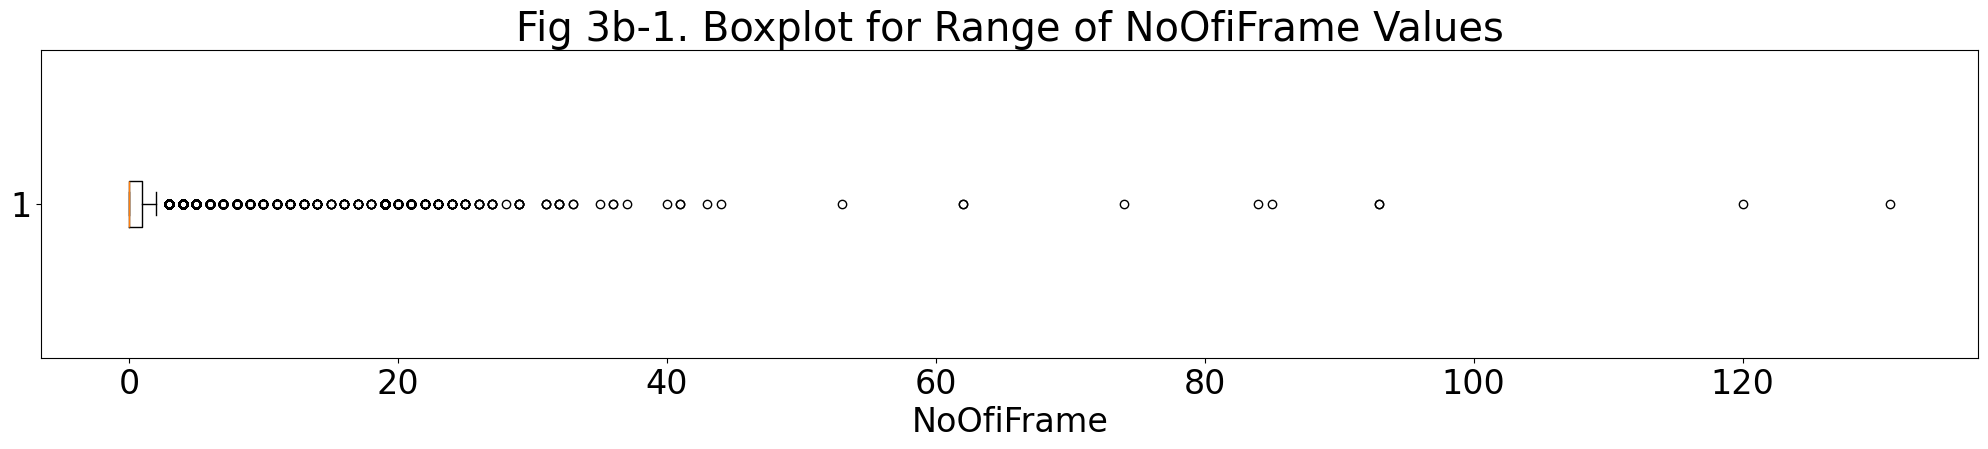

In [17]:
# Inspect range of NoOfiFrame values

plt.figure(figsize=(25, 4))
plt.boxplot(df["NoOfiFrame"].dropna(), vert=False)
plt.title("Fig 3b-1. Boxplot for Range of NoOfiFrame Values")
plt.xlabel("NoOfiFrame")
plt.show()


**Analysis of NoOfiFrame**: the distribution clusters mainly around 0-1 iFrames per page, with a number of right-skewed outliers. Internet research suggests that sites with as many as hundreds of iFrames are possible and are indeed significantly associated with malicious sites, so we will take the presence of such outliers as useful signals for the model.

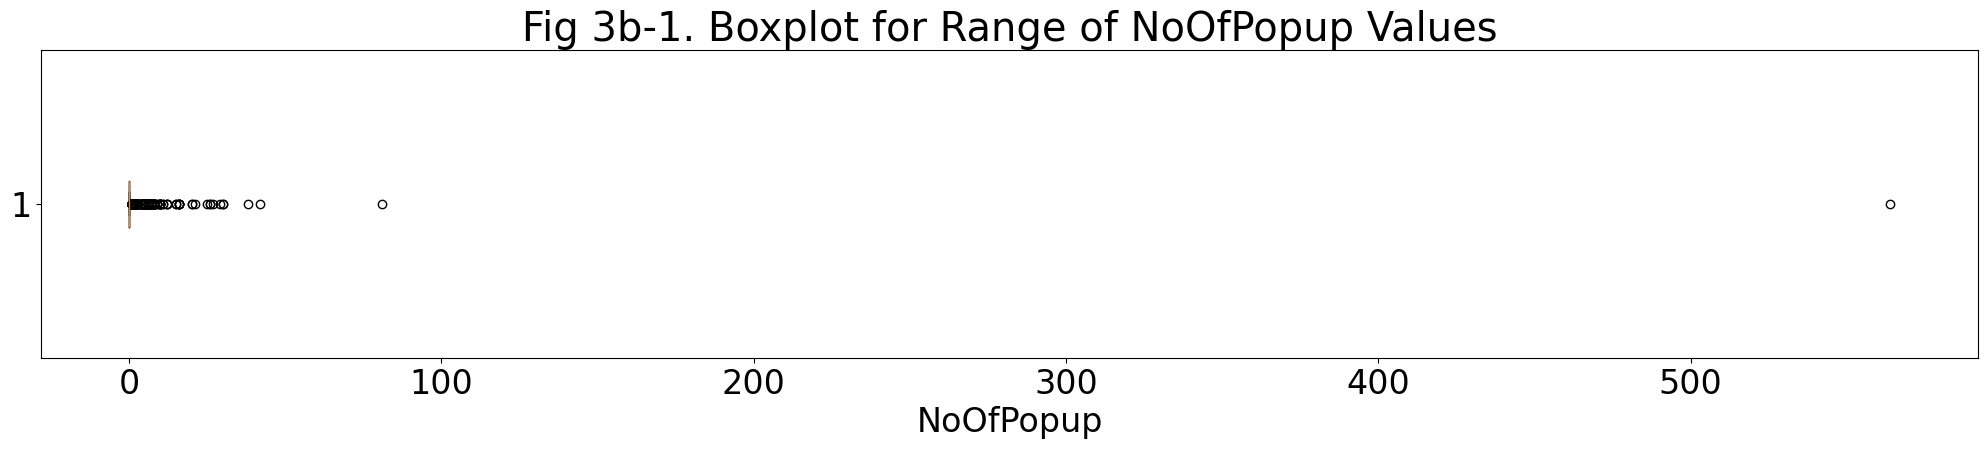

In [18]:
# Inspect range of NoOfPopup values

plt.figure(figsize=(25, 4))
plt.boxplot(df["NoOfPopup"].dropna(), vert=False)
plt.title("Fig 3b-1. Boxplot for Range of NoOfPopup Values")
plt.xlabel("NoOfPopup") 
plt.show()

**Analysis of NoOfPopup**: the distribution clusters mainly around 0-1 popups per page, with a number of right-skewed outliers. Internet research suggests that sites with as many as hundreds of attempted popups are also possible and are indeed significantly associated with malicious sites, so we will take the presence of such outliers as useful signals for the model.

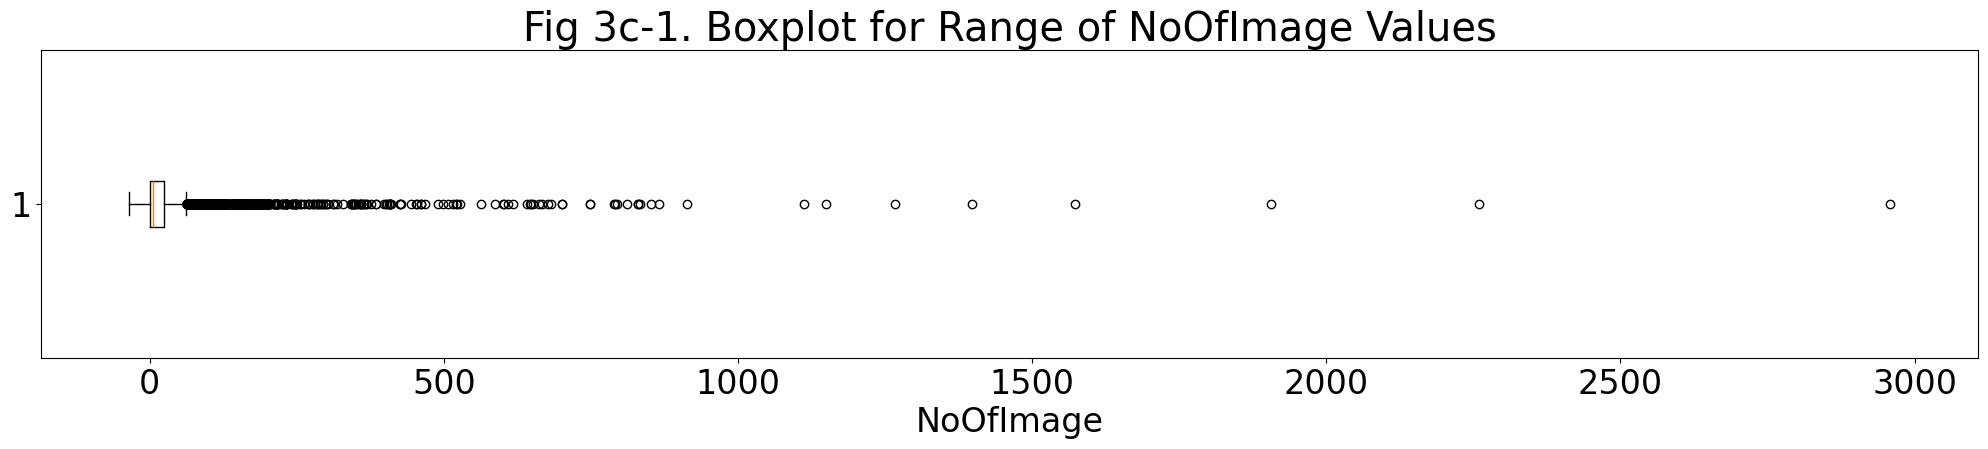

In [19]:
# Inspect range of NoOfImage values

plt.figure(figsize=(25, 4))
plt.boxplot(df[df["NoOfImage"] < 1000000]["NoOfImage"].dropna(), vert=False)
plt.title("Fig 3c-1. Boxplot for Range of NoOfImage Values")
plt.xlabel("NoOfImage")
plt.show()

In [20]:
df[df.NoOfImage < 0]["NoOfImage"].value_counts()

NoOfImage
-33    80
-31    79
-35    78
-32    71
-34    69
Name: count, dtype: int64

**Analysis of NoOfImage**: There are significant and extreme right-skewed outliers for NoOfImage, which could again serve as signals for the target (i.e. is a malicious site). However, we have also detected a fair number of negative values for this variable (~377). A quick check of summary statistics reveals that the subset of websites recorded as having < 0 images is much more likely to be labeled a benign site (~81%) than the population average (>55%). We cannot discount the possibility that the generation of negative values is a meaningful signal, so we will impute with median but add a flag to indicate the presence of negative values, and iterate the model as needed later.

In [21]:
df[df.NoOfImage < 0].describe()

,Unnamed: 0,LineOfCode,LargestLineLength,NoOfURLRedirect,NoOfSelfRedirect,NoOfPopup,NoOfiFrame,NoOfImage,NoOfSelfRef,NoOfExternalRef,Robots,IsResponsive,DomainAgeMonths,label,LineOfCodeIsMissing
count,377.00,377.00,377.00,377.00,377.00,377.00,377.00,377.00,377.00,377.00,377.00,377.00,377.00,377.00,377.00
mean,5349.63,1538.17,8585.16,0.10,0.03,0.10,2.13,-32.99,115.18,84.79,0.53,0.92,49.28,0.81,0.11
std,3079.96,2267.17,15928.81,0.30,0.18,0.39,3.85,1.43,183.22,72.90,0.50,0.27,32.23,0.39,0.32
min,2.00,0.00,218.00,0.00,0.00,0.00,0.00,-35.00,0.00,2.00,0.00,0.00,0.00,0.00,0.00
25%,2602.00,620.00,1336.00,0.00,0.00,0.00,0.00,-34.00,50.00,28.00,0.00,1.00,25.00,1.00,0.00
50%,5570.00,1080.00,5649.00,0.00,0.00,0.00,1.00,-33.00,86.00,68.00,1.00,1.00,45.00,1.00,0.00
75%,8015.00,1688.00,9381.00,0.00,0.00,0.00,2.00,-32.00,135.00,119.00,1.00,1.00,65.00,1.00,0.00
max,10488.00,25791.00,209757.00,1.00,1.00,3.00,36.00,-31.00,2950.00,500.00,1.00,1.00,119.00,1.00,1.00


In [22]:
# Create negative value flag and replace negative values with 0

df["NoOfImagesInvalid"] = np.where(df.NoOfImage < 0, 1, 0)
df["NoOfImage"] = df["NoOfImage"].apply(lambda x: x if x >= 0 else 0)

### 3c. Clean Up Labels

Strip whitespace from categorical labels.

In [23]:
for col in df.columns:
    if col in ["Industry", "HostingProvider"]:
        df[col] = df[col].str.strip()

## 4. Data Analysis and Visualisation<a id='4'></a>
[Return to Table of Contents](#0)

In [24]:
### Admin helper functions to help with viz

# Function to group dataset for stacked bar chart viz
def reformat_df(df, dep_col, indep_col, label_order):
    # Aggregate columns
    count_df = df.groupby([dep_col, indep_col]).size().unstack(fill_value=0)
    count_df = count_df[label_order]
    return count_df.div(count_df.sum(axis=1), axis=0)


In [25]:
### Admin helper diagnostic function to test for: support, lift, dependence of feature on variable

def chi_sq_and_cramers_v(contingency):
    
    # Calculate chi2 p-score
    chi2, p, _, expected = chi2_contingency(contingency, correction = False)
    min_expected = expected.min()

    #Cramers V
    n = contingency.sum()
    r, k = contingency.shape
    if n == 0:
        v = np.nan
    else:
        v = np.sqrt((chi2 / n) / max(1, min(r - 1, k - 1)))

    return chi2, p, v, min_expected

def feature_diagnostic(
    df: pd.DataFrame,
    label: str,
    feature: str,
    *,
    classes = None,
    min_count: int = 30,
    lift_tol: float = 0.1,
    max_frac_outside: float = 0.20):

    #Build list of classes
    if classes is None:
        classes = list(pd.unique(df[label]))
    try:
        classes = sorted(classes)
    except Exception:
        pass

    #Base rate vector
    base_counts = df[label].value_counts().reindex(classes, fill_value = 0)
    n_total = int(base_counts.sum())
    base_p = (base_counts/n_total) if n_total > 0 else pd.Series([np.nan]*len(classes), index=classes)

    #Contingency table 
    c = pd.crosstab(df[feature], df[label])

    # chi2 score, p, and effect size
    chi2, p, v, min_expected = chi_sq_and_cramers_v(c.values)

    #Per-category support
    cat_n = c.sum(axis = 1).rename("n")
    #Filter to categories with enough support to list in details
    kept_cats = cat_n[cat_n >= min_count].index
    unkept_cats = cat_n[cat_n < min_count].index
    ct_kept = c.loc[kept_cats]

    # Per-category diagnostics

    detail = (
        ct_kept
        .stack()
        .rename("count")
        .reset_index()
        .rename(columns={feature: "category", label: "class"})
    )

    # Conditional probability P(y=class | category)
    # Compute from kept table for numerical stability
    denom = ct_kept.sum(axis=1).replace(0, np.nan)
    p_y_given_cat = (ct_kept.T / denom).T  # rows: category, cols: class
    p_long = (
        p_y_given_cat
        .stack()
        .rename("p_y_given_cat")
        .reset_index()
        .rename(columns={feature: "category", label: "class"})
    )

    detail = detail.merge(p_long, on=["category", "class"], how="left")

    # Base probability for each class
    detail["base_p"] = detail["class"].map(base_p)

    # Lift per class: P(y=c|cat)/P(y=c)
    detail["lift"] = detail["p_y_given_cat"] / detail["base_p"].replace(0, np.nan)

    # Lift deviation from baseline per class
    detail["lift_dev_from_baseline"] = abs(detail["lift"] - 1.0)

    # Add per-category n
    detail["n"] = detail["category"].map(cat_n)

    # Sort values for detail to rank by biggest deviations 
    detail = detail.sort_values(["category", "class"])

    # Per-category “distance from baseline” summaries
    per_category = (
        detail
        .groupby("category", as_index=False)
        .agg(
            n=("n", "first"),
            l1_dist=("p_y_given_cat", lambda s: np.nan),  # placeholder
            max_abs_lift_dev=("lift", lambda s: float(np.nanmax(np.abs(s - 1.0))) if len(s) else np.nan),
            frac_classes_outside_tol=("lift", lambda s: float(np.mean(np.abs(s - 1.0) > lift_tol)) if len(s) else np.nan),
        )
    )

    # Compute L1 distance properly using pivoted distributions
    dist_df = p_y_given_cat.copy()
    for cl in classes:
        dist_df[cl] = (dist_df[cl] - base_p[cl]).abs()
    l1 = dist_df.sum(axis=1).rename("l1_dist")
    per_category = per_category.merge(l1.reset_index().rename(columns={feature: "category"}), on="category", how="left")
    per_category["l1_dist"] = per_category["l1_dist_y"]
    per_category = per_category.drop(columns=["l1_dist_x", "l1_dist_y"])

    # Base-rate-ish heuristic across categories: most classes’ lifts near 1 for most categories
    if len(per_category) == 0:
        base_rate_tracker = np.nan
        frac_cats_outside = np.nan
        note = "no categories >= min_count"
    else:
        # Flag category as “outside” if ANY class deviates beyond tol
        cat_outside = per_category["max_abs_lift_dev"] > lift_tol
        frac_cats_outside = float(cat_outside.mean())
        base_rate_tracker = frac_cats_outside <= max_frac_outside
        note = ""

    summary = {
            "feature": feature,
            "total_n": n_total,
            "all_above_min_expected": bool(min_expected >= 5),
            "n_categories": int(c.shape[0]),
            "n_categories_used": int(len(ct_kept)),
            "kept_categories": str(kept_cats.values),
            "unkept_categories": str(unkept_cats.values),
            "n_classes": int(len(classes)),
            "chisq_p_value": float(p),
            "cramers_v": float(v), 
            "base_rate_tracker": base_rate_tracker,
            "categories_outside_lift_tol": ", ".join(str(x) for x in per_category[cat_outside]["category"].tolist()),
            "frac_categories_outside_lift_tol": frac_cats_outside,
            "max_category_l1_dist": float(per_category["l1_dist"].max()) if len(per_category) else np.nan,
            "note": note,
    }

    return summary, detail

# Admin Helper function for ANOVA for numerical feature analysis

def anova(df, cat_col, num_col):
    groups = [df[df[cat_col] == g][num_col].dropna() for g in df[cat_col].unique()]
    
    # Make sure there are at least 2 groups with data
    if len(groups) < 2 or any(len(g) == 0 for g in groups):
        print(f'{num_col}: Not enough data to run ANOVA.')
        return
    
    f_stat, p = f_oneway(*groups)
    return f_stat, p



### Analyses of Impact of Categorical Variables on Label<a id='4-1'></a>
[Skip to Numeric Section](#4-2)

### 4a. General Distribution of Label

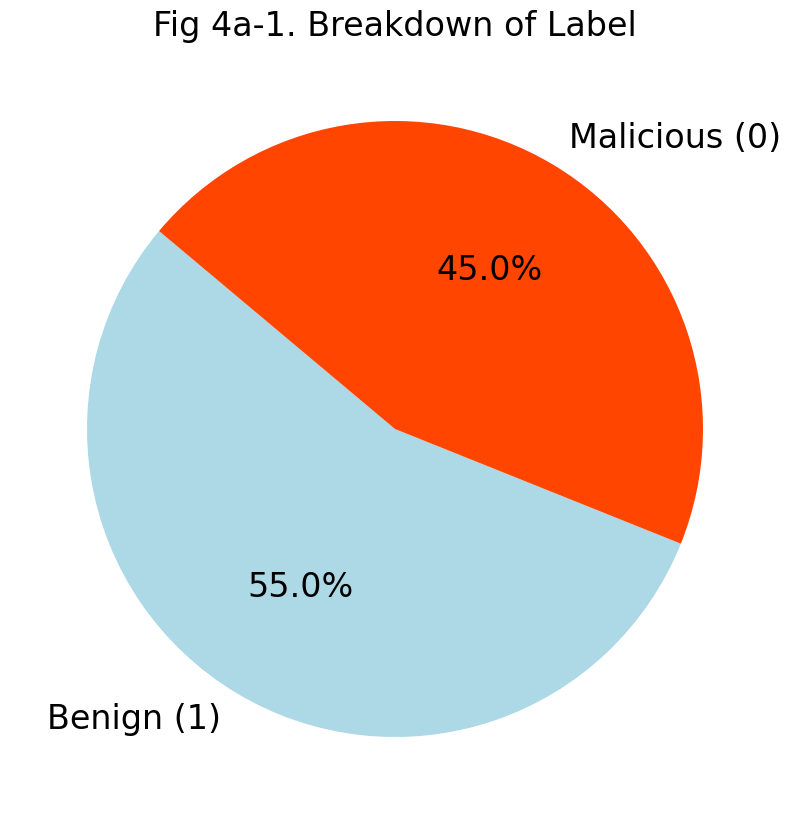

In [26]:
# Looking at label occurrence

plt.figure(figsize=(25,10))
plt.title("Fig 4a-1. Breakdown of Label", fontsize = 24)
plt.pie(
    df.label.value_counts(), 
    labels=[f'Malicious ({lbl})' if lbl == 0 else f'Benign ({lbl})' for lbl in df.label.value_counts().index], 
        autopct='%1.1f%%', startangle=140, textprops={'fontsize': 24}, colors = ["lightblue", "orangered"])
plt.show()

**Observations**
- Fig 4a-1 indicates that about 45% of sites in the sample were classed as malicious (0), so the distribution is roughly equal (but also that this likely does not represent a randomized sample of sites). This likely represents a higher incidence of the positive class than the true prevalence of spam sites in the population, so the model and model evaluation will have to take this into account, i.e. the test and validation sets may need to be weighted to reflect the actual population distribution.  

### 4b. Impact of NoOfURLRedirect on Label

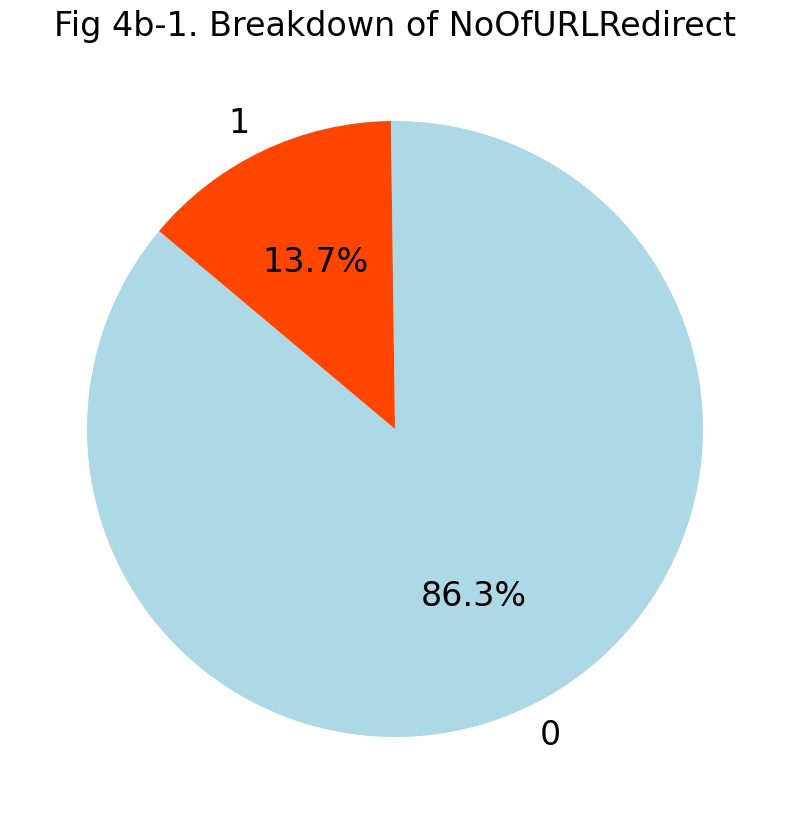

In [27]:
# Show NoOfURLRedirect breakdown

plt.figure(figsize=(25,10))
plt.title("Fig 4b-1. Breakdown of NoOfURLRedirect", fontsize = 24)
plt.pie(df.NoOfURLRedirect.value_counts(), labels = df.NoOfURLRedirect.value_counts().index, 
        autopct='%1.1f%%', startangle=140, textprops={'fontsize': 24}, colors = ["lightblue", "orangered"])
plt.show()

**Observations:**

- About 14% of sites involved a URL redirect. Note that while the name of the column had suggested that this was a numeric variable, we treat it as categorical since the values are binary, and interpret as absence/presence of URL redirects.

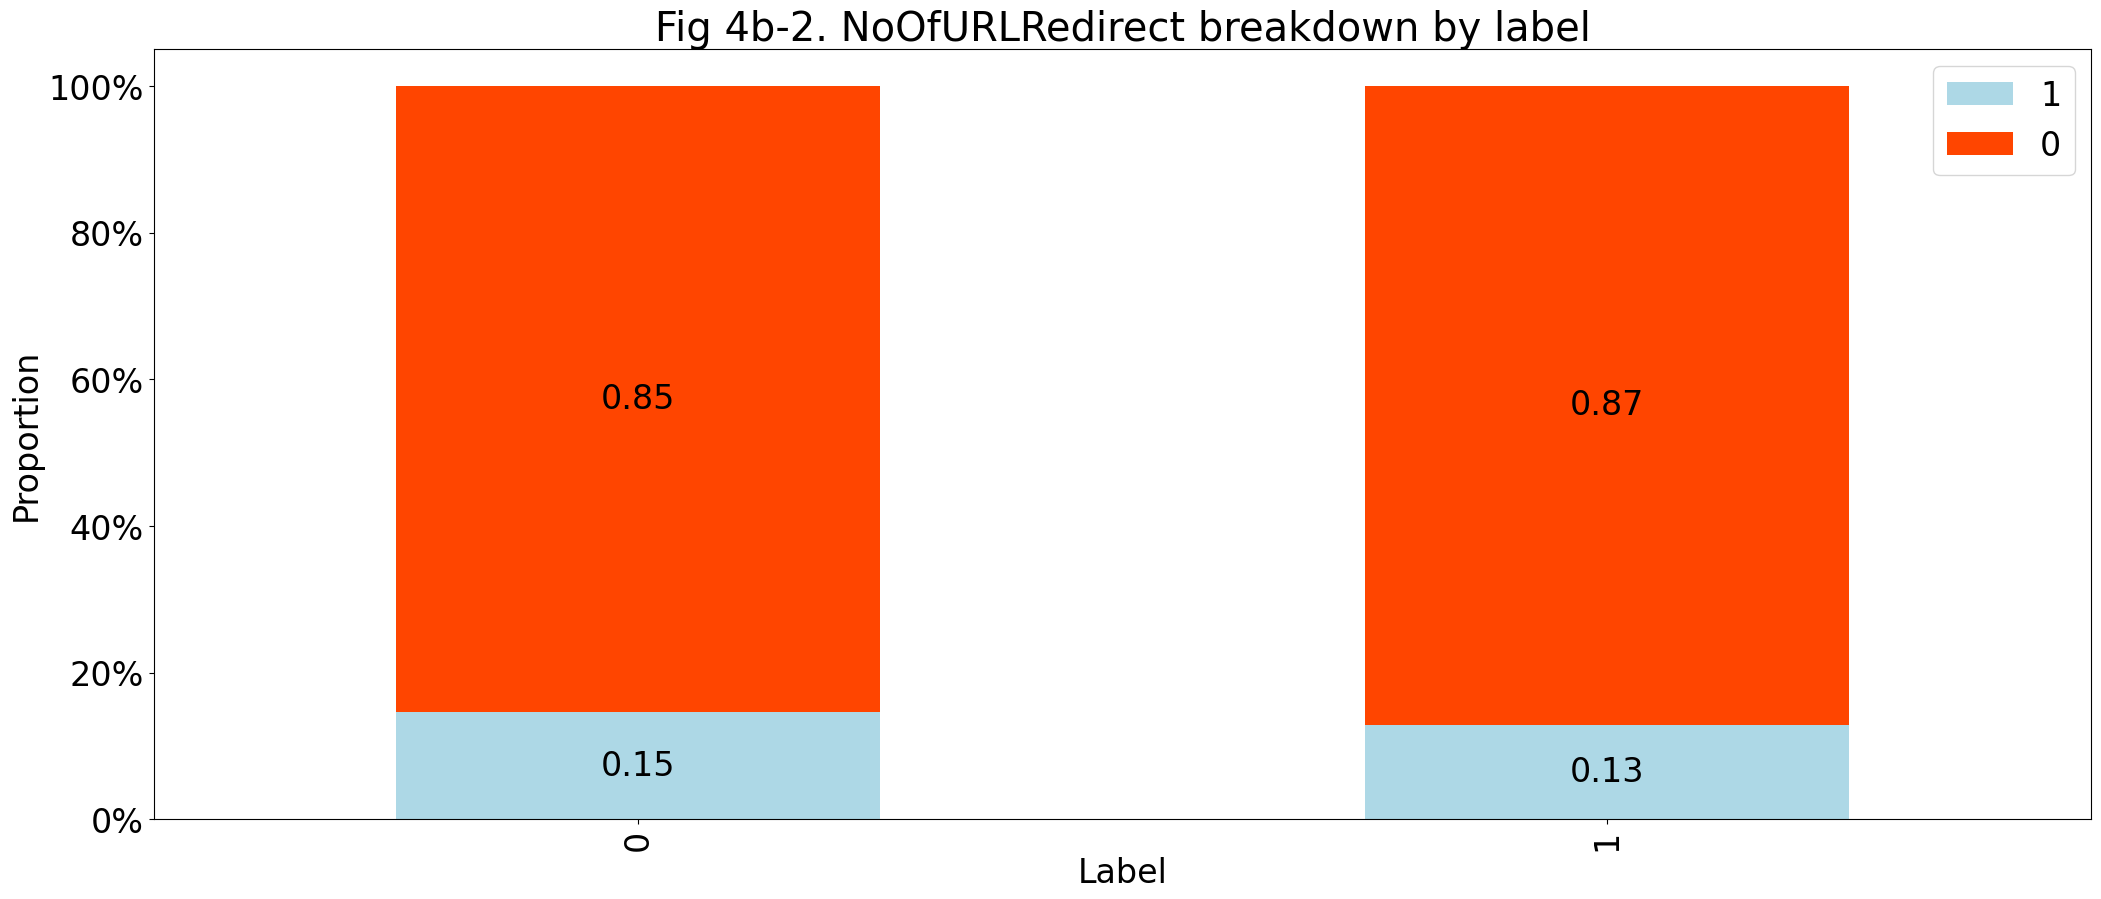

In [28]:
# Relationship between NoOfURLRedirect and label

df_4b1 = reformat_df(df, "label", "NoOfURLRedirect", [1, 0])
ax_4b1 = df_4b1.plot(kind='bar', stacked=True, color = ["lightblue", "orangered"])
plt.title('Fig 4b-2. NoOfURLRedirect breakdown by label')
plt.xlabel('Label')
plt.ylabel('Proportion')
plt.gca().yaxis.set_major_formatter(lambda x, _: f'{x * 100:.0f}%')
plt.legend()

for c in ax_4b1.containers:
    ax_4b1.bar_label(c, label_type='center',  fmt= '%.2f')

plt.show()

In [29]:
# Feature Diagnostic on NoOfURLRedirect and label
summary, detail = feature_diagnostic(df, "label", "NoOfURLRedirect")

for val in summary:
    print("\033[1m" + val + "\033[0m", ": ", summary[val])

print(detail)

feature :  NoOfURLRedirect
total_n :  10500
all_above_min_expected :  True
n_categories :  2
n_categories_used :  2
kept_categories :  [0 1]
unkept_categories :  []
n_classes :  2
chisq_p_value :  0.013326221644266325
cramers_v :  0.02415284565763927
base_rate_tracker :  True
categories_outside_lift_tol :  
frac_categories_outside_lift_tol :  0.0
max_category_l1_dist :  0.06037193261705798
note :  
   category  class  count  p_y_given_cat  base_p  lift  \
0         0      0   4032           0.44    0.45  0.99   
1         0      1   5032           0.56    0.55  1.01   
2         1      0    689           0.48    0.45  1.07   
3         1      1    747           0.52    0.55  0.95   

   lift_dev_from_baseline     n  
0                    0.01  9064  
1                    0.01  9064  
2                    0.07  1436  
3                    0.05  1436  


**Observations**
- Fig 4b-2 shows that prevalence of URL Redirects is slightly higher (2%) in malicious sites than in benign sites.
- However, a diagnostic test of the feature indicates that while the chi2 test p-score is significant at 95% confidence, the strength of association between this feature and the label is weak (at Cramer's V ~ 0.02). Neither categories provide significant lift to the label, or deviates meaningfully from the baseline. 
- It is unlikely therefore that this feature on its own can be considered a strong predictor for the label. 

### 4c. Impact of NoOfSelfRedirect on Label

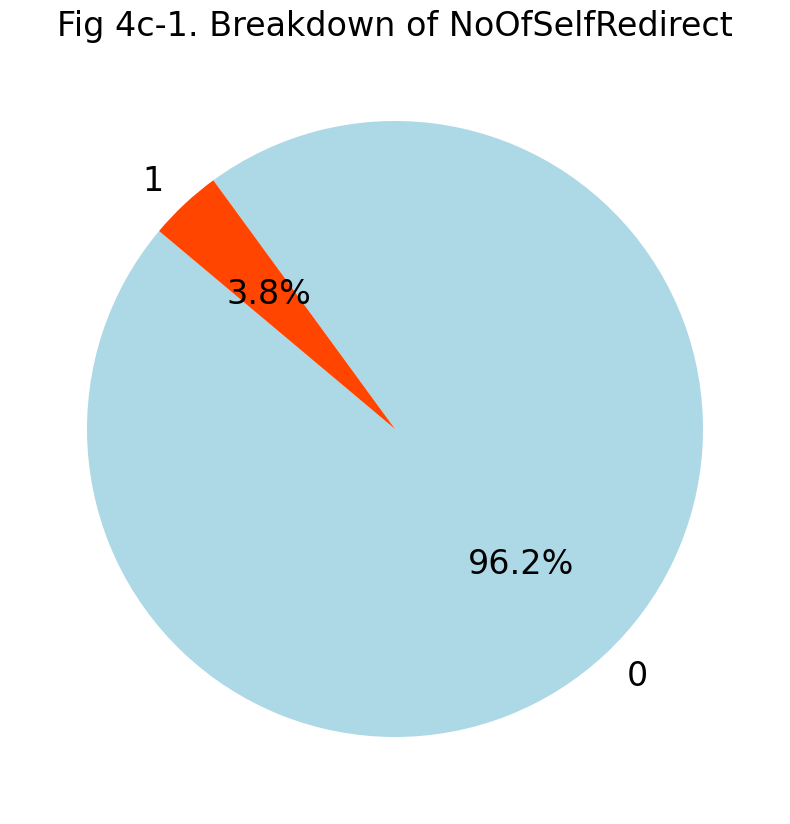

In [30]:
# Show NoOfURLRedirect breakdown

plt.figure(figsize=(25,10))
plt.title("Fig 4c-1. Breakdown of NoOfSelfRedirect", fontsize = 24)
plt.pie(df.NoOfSelfRedirect.value_counts(), labels = df.NoOfSelfRedirect.value_counts().index, 
        autopct='%1.1f%%', startangle=140, textprops={'fontsize': 24}, colors = ["lightblue", "orangered"])
plt.show()

**Observations:**

- About 4% of sites displayed self-redirect behavior. Note that, similarly to NoOfURLRedirect, we interpret the column as a binary indicator of whether such behaviour was observed. 

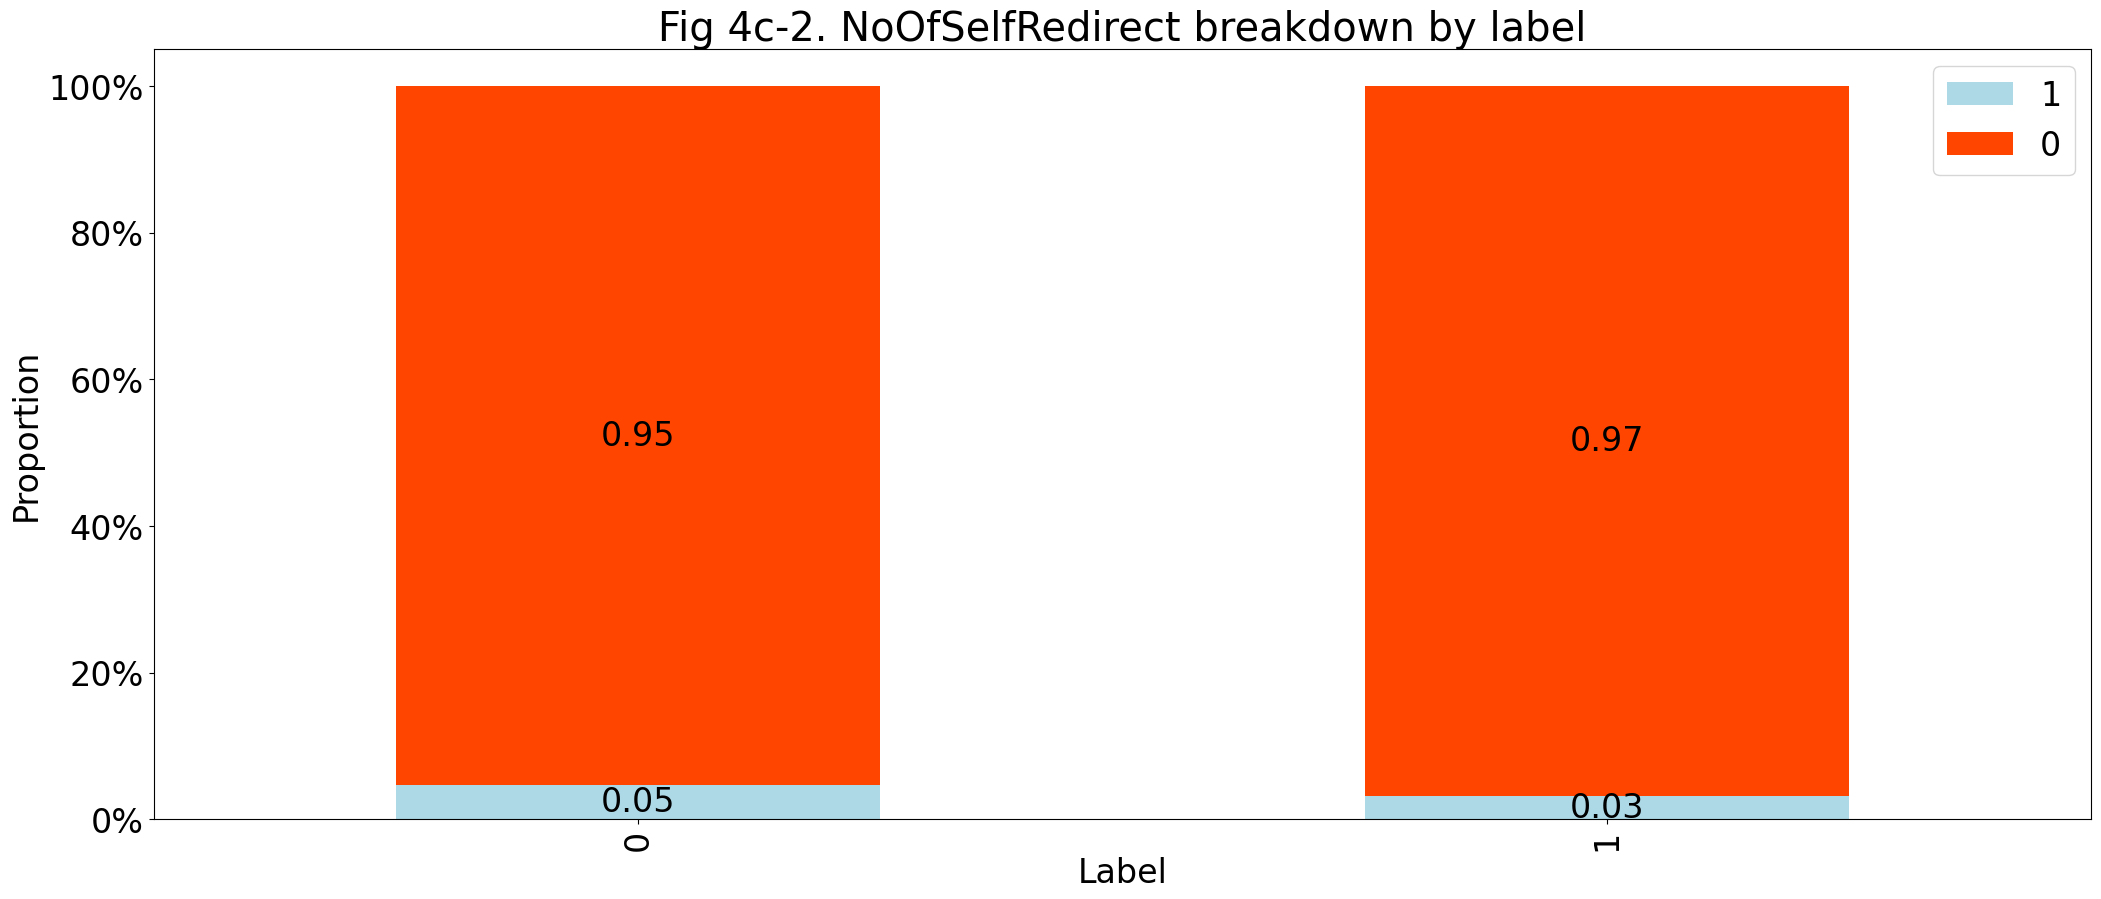

In [31]:
# Relationship between NoOfSelfRedirect and label

df_4c1 = reformat_df(df, "label", "NoOfSelfRedirect", [1, 0])
ax_4c1 = df_4c1.plot(kind='bar', stacked=True, color = ["lightblue", "orangered"])
plt.title('Fig 4c-2. NoOfSelfRedirect breakdown by label')
plt.xlabel('Label')
plt.ylabel('Proportion')
plt.gca().yaxis.set_major_formatter(lambda x, _: f'{x * 100:.0f}%')
plt.legend()

for c in ax_4c1.containers:
    ax_4c1.bar_label(c, label_type='center',  fmt= '%.2f')

plt.show()

In [32]:
# Feature Diagnostic on NoOfSelfRedirect and label
summary, detail = feature_diagnostic(df, "label", "NoOfSelfRedirect")

for val in summary:
    print("\033[1m" + val + "\033[0m", ": ", summary[val])

print(detail)

feature :  NoOfSelfRedirect
total_n :  10500
all_above_min_expected :  True
n_categories :  2
n_categories_used :  2
kept_categories :  [0 1]
unkept_categories :  []
n_classes :  2
chisq_p_value :  0.00013903446604427965
cramers_v :  0.037180618097002
base_rate_tracker :  False
categories_outside_lift_tol :  1
frac_categories_outside_lift_tol :  0.5
max_category_l1_dist :  0.18492032060348895
note :  
   category  class  count  p_y_given_cat  base_p  lift  \
0         0      0   4502           0.45    0.45  0.99   
1         0      1   5594           0.55    0.55  1.01   
2         1      0    219           0.54    0.45  1.21   
3         1      1    185           0.46    0.55  0.83   

   lift_dev_from_baseline      n  
0                    0.01  10096  
1                    0.01  10096  
2                    0.21    404  
3                    0.17    404  


**Observations**
- Fig 4c-2 shows that again, prevalence of self-redirects is slightly higher amongst malicious sites than benign ones.
- The diagnostic test shows that while chisq p is significant, the strength of association is low (Cramer's V ~ 0.03), though NoOfSelfRedirect = 1 results in some meaningful difference from the base rate. 
- In other words, there is an actual, though weak, association, though only provides signal in rare cases where there are website self-redirects. Therefore it can only serve as a meaningful signal in a small subset of situations. 

### 4d. Impact of Robots on Label

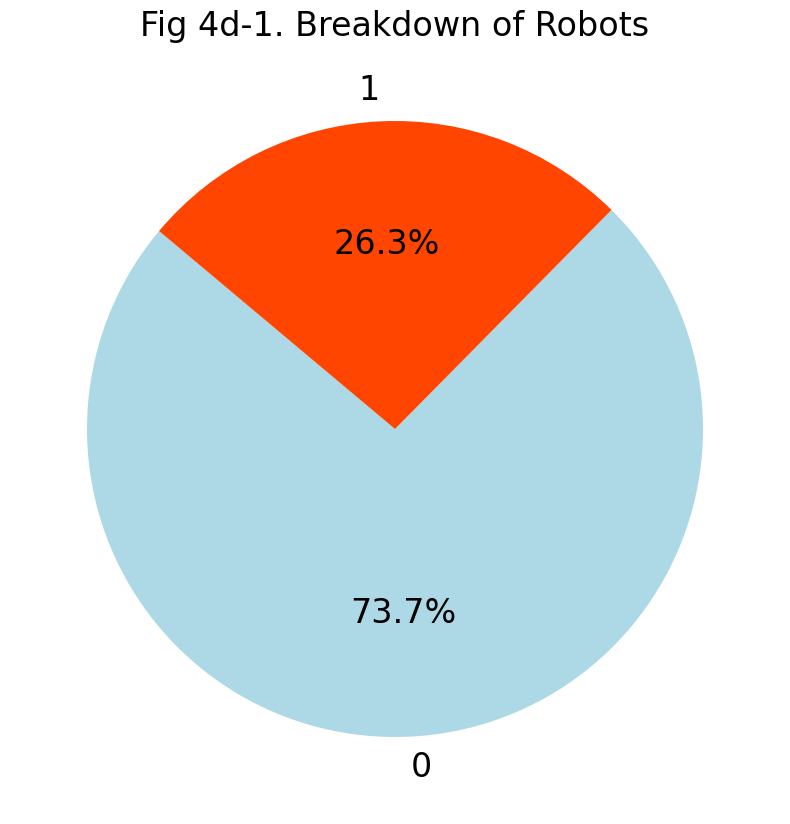

In [33]:
# Show Robots breakdown

plt.figure(figsize=(25,10))
plt.title("Fig 4d-1. Breakdown of Robots", fontsize = 24)
plt.pie(df.Robots.value_counts(), labels = df.Robots.value_counts().index, 
        autopct='%1.1f%%', startangle=140, textprops={'fontsize': 24}, colors = ["lightblue", "orangered"])
plt.show()

**Observations:**
- About three quarters of sites had no robots.txt, which is a surprising proportion and probably not indicative of the population level distribution. 

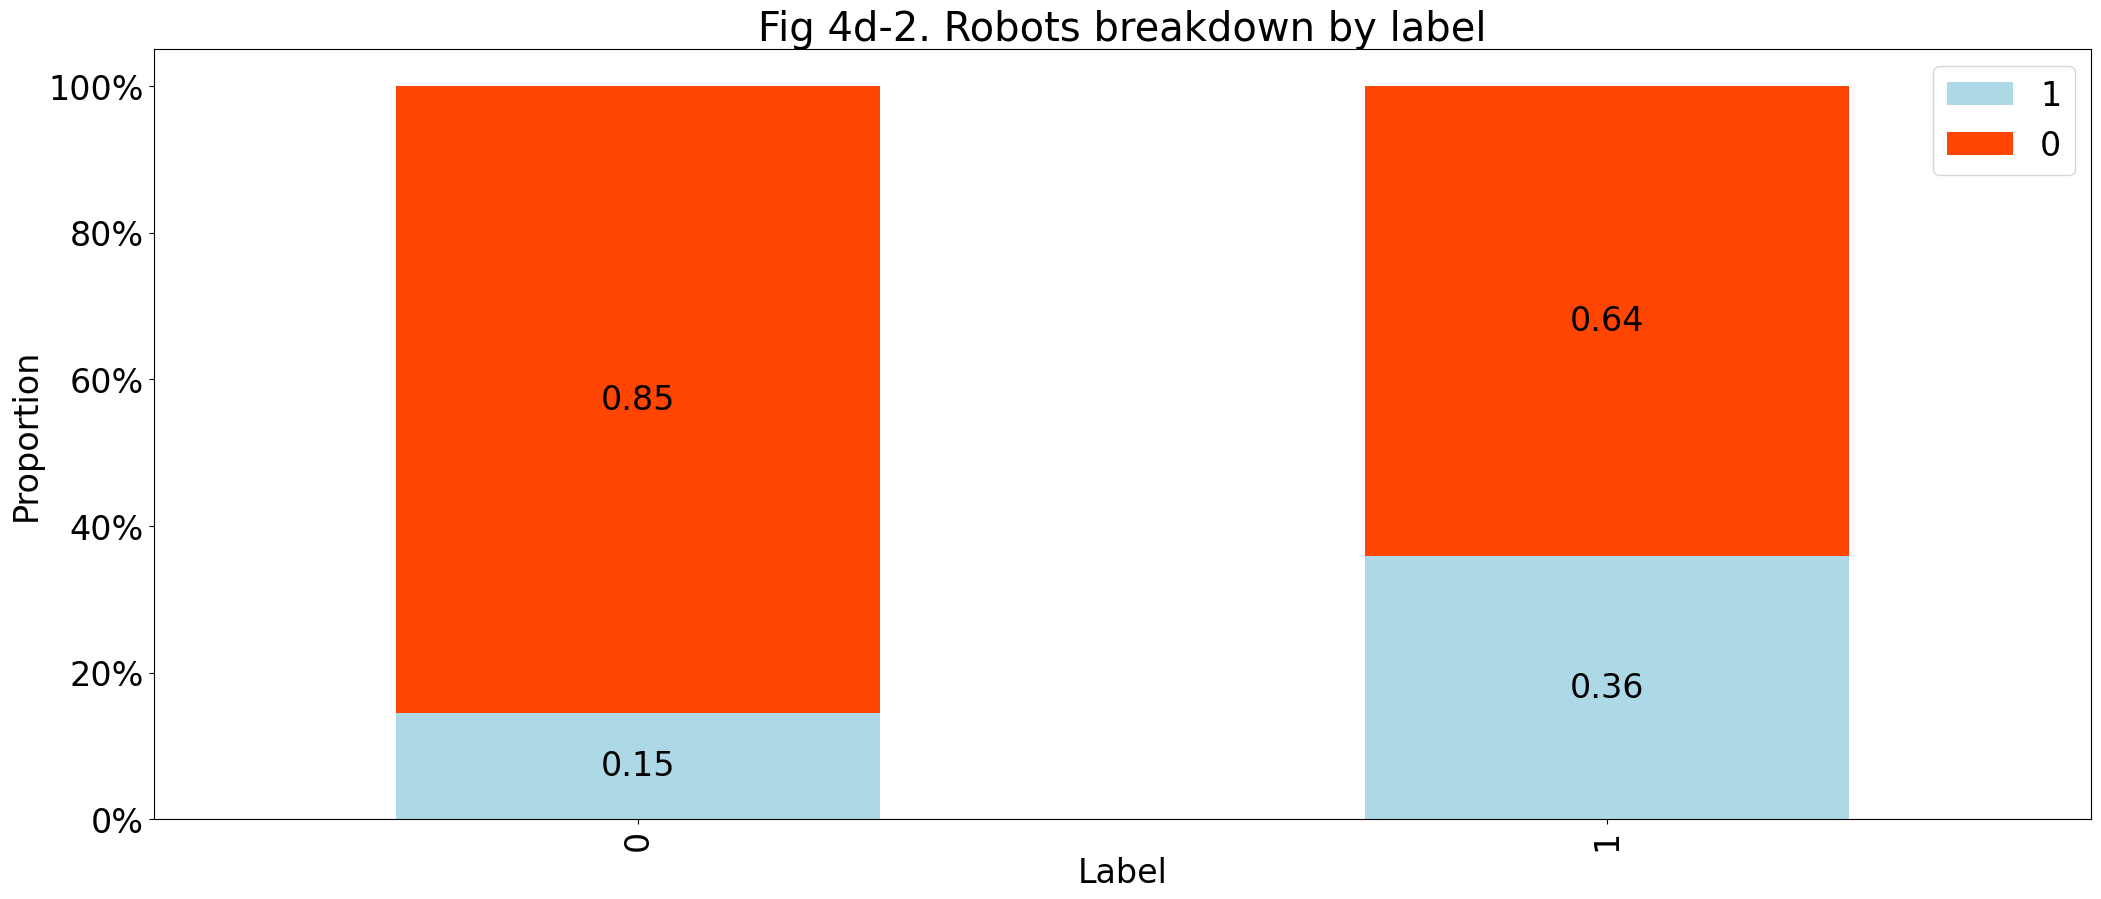

In [34]:
# Relationship between Robots and label

df_4d1 = reformat_df(df, "label", "Robots", [1, 0])
ax_4d1 = df_4d1.plot(kind='bar', stacked=True, color = ["lightblue", "orangered"])
plt.title('Fig 4d-2. Robots breakdown by label')
plt.xlabel('Label')
plt.ylabel('Proportion')
plt.gca().yaxis.set_major_formatter(lambda x, _: f'{x * 100:.0f}%')
plt.legend()

for c in ax_4d1.containers:
    ax_4d1.bar_label(c, label_type='center',  fmt= '%.2f')

plt.show()

In [35]:
# Feature Diagnostic on Robots and label
summary, detail = feature_diagnostic(df, "label", "Robots")

for val in summary:
    print("\033[1m" + val + "\033[0m", ": ", summary[val])

print(detail)

feature :  Robots
total_n :  10500
all_above_min_expected :  True
n_categories :  2
n_categories_used :  2
kept_categories :  [0 1]
unkept_categories :  []
n_classes :  2
chisq_p_value :  3.125655532584047e-135
cramers_v :  0.24153206000069039
base_rate_tracker :  False
categories_outside_lift_tol :  0, 1
frac_categories_outside_lift_tol :  1.0
max_category_l1_dist :  0.40231668995015607
note :  
   category  class  count  p_y_given_cat  base_p  lift  \
0         0      0   4035           0.52    0.45  1.16   
1         0      1   3704           0.48    0.55  0.87   
2         1      0    686           0.25    0.45  0.55   
3         1      1   2075           0.75    0.55  1.37   

   lift_dev_from_baseline     n  
0                    0.16  7739  
1                    0.13  7739  
2                    0.45  2761  
3                    0.37  2761  


**Observations**
- Fig 4d-2 suggests that the prevalence of a Robots.txt file in malicious sites is much lower (15%) than in benign sites (36%).
- The diagnostic test suggests that the presence and absence of Robots is likely a robust and stable predictor for the label, with a large association (Cramer's V ~ 0.24) and significant lift provided by both categories of Robots. In other words, both 1 and 0 values of Robots will change the distribution significantly from baseline.   
- One possible explanation is that creators of malicious sites don't bother generating robots.txt files since these files, which inform web crawlers what not to index, don't contribute to the main function of entrapping hapless victims

### 4e. Impact of IsResponsive on Label

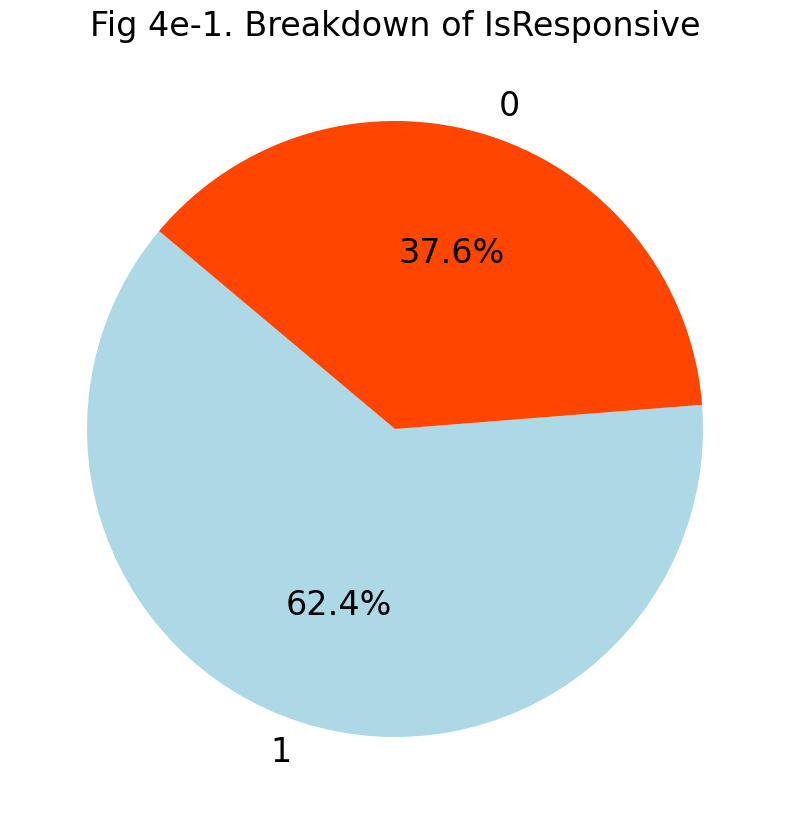

In [36]:
# Show IsResponsive breakdown

plt.figure(figsize=(25,10))
plt.title("Fig 4e-1. Breakdown of IsResponsive", fontsize = 24)
plt.pie(df.IsResponsive.value_counts(), labels = df.IsResponsive.value_counts().index, 
        autopct='%1.1f%%', startangle=140, textprops={'fontsize': 24}, colors = ["lightblue", "orangered"])
plt.show()

**Observations**
- About 60% of sites are configured so that they can be adapted across different devices. 

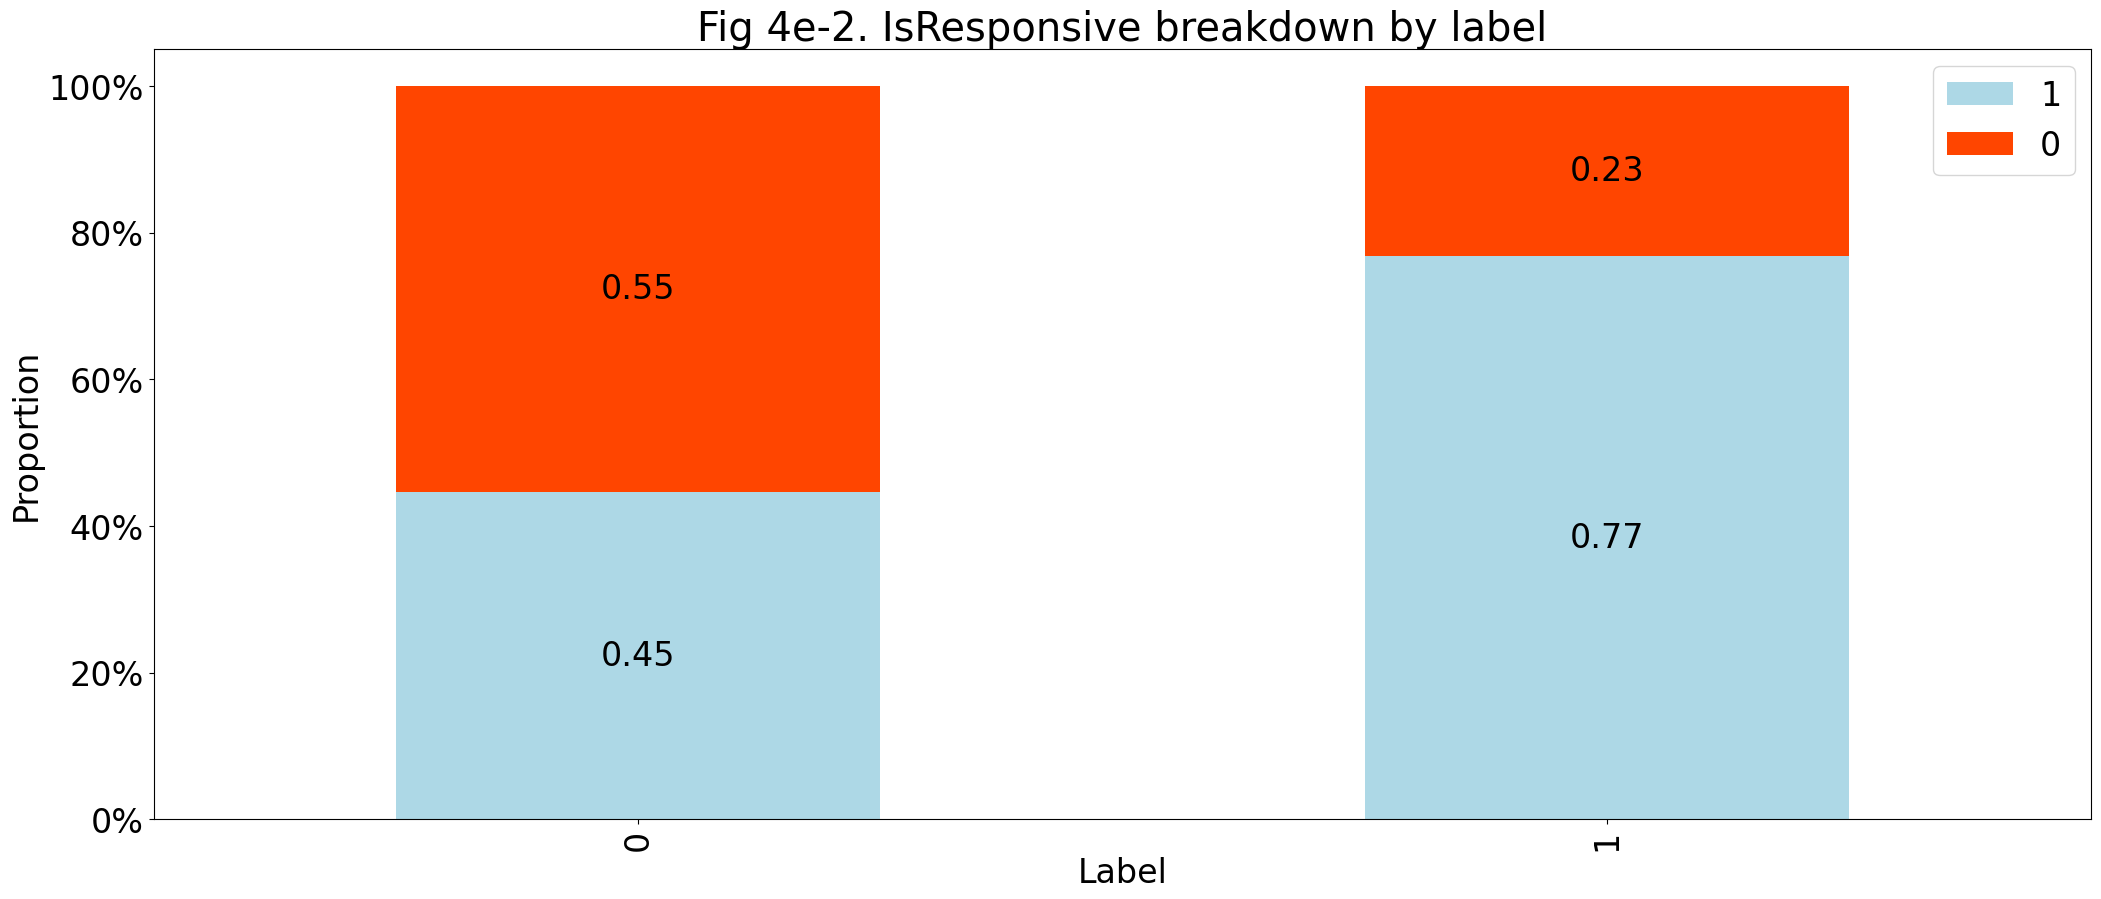

In [37]:
# Relationship between IsResponsive and label

df_4e1 = reformat_df(df, "label", "IsResponsive", [1, 0])
ax_4e1 = df_4e1.plot(kind='bar', stacked=True, color = ["lightblue", "orangered"])
plt.title('Fig 4e-2. IsResponsive breakdown by label')
plt.xlabel('Label')
plt.ylabel('Proportion')
plt.gca().yaxis.set_major_formatter(lambda x, _: f'{x * 100:.0f}%')
plt.legend()

for c in ax_4e1.containers:
    ax_4e1.bar_label(c, label_type='center',  fmt= '%.2f')

plt.show()

In [38]:
# Feature Diagnostic on IsResponsive and label
summary, detail = feature_diagnostic(df, "label", "IsResponsive")

for val in summary:
    print("\033[1m" + val + "\033[0m", ": ", summary[val])

print(detail)

feature :  IsResponsive
total_n :  10500
all_above_min_expected :  True
n_categories :  2
n_categories_used :  2
kept_categories :  [0 1]
unkept_categories :  []
n_classes :  2
chisq_p_value :  1.1570409122946362e-250
cramers_v :  0.33000802775740146
base_rate_tracker :  False
categories_outside_lift_tol :  0, 1
frac_categories_outside_lift_tol :  1.0
max_category_l1_dist :  0.42262425294004247
note :  
   category  class  count  p_y_given_cat  base_p  lift  \
0         0      0   2612           0.66    0.45  1.47   
1         0      1   1340           0.34    0.55  0.62   
2         1      0   2109           0.32    0.45  0.72   
3         1      1   4439           0.68    0.55  1.23   

   lift_dev_from_baseline     n  
0                    0.47  3952  
1                    0.38  3952  
2                    0.28  6548  
3                    0.23  6548  


**Observations**
- Fig 4e-2 suggests that the prevalence of IsResponsive is higher amongst benign (77%) than malicious sites (45%) - in other words, a greater proportion of benign sites are designed to be adaptive across devices.  
- The diagnostic test suggests that the prevalence of IsResponsive is likely a robust and stable predictor for the label, with a large association (Cramer's V ~ 0.33) and significant lift provided by both categories of IsResponsive. In other words, both 1 and 0 values of IsResponsive will change the distribution significantly from baseline.   
- One possible explanation is that creators of malicious sites tend to bother less with adapting their sites to be platform-adaptive, since that requires engineering overhead unnecessary for their use case.

### 4f. Impact of Industry on Label

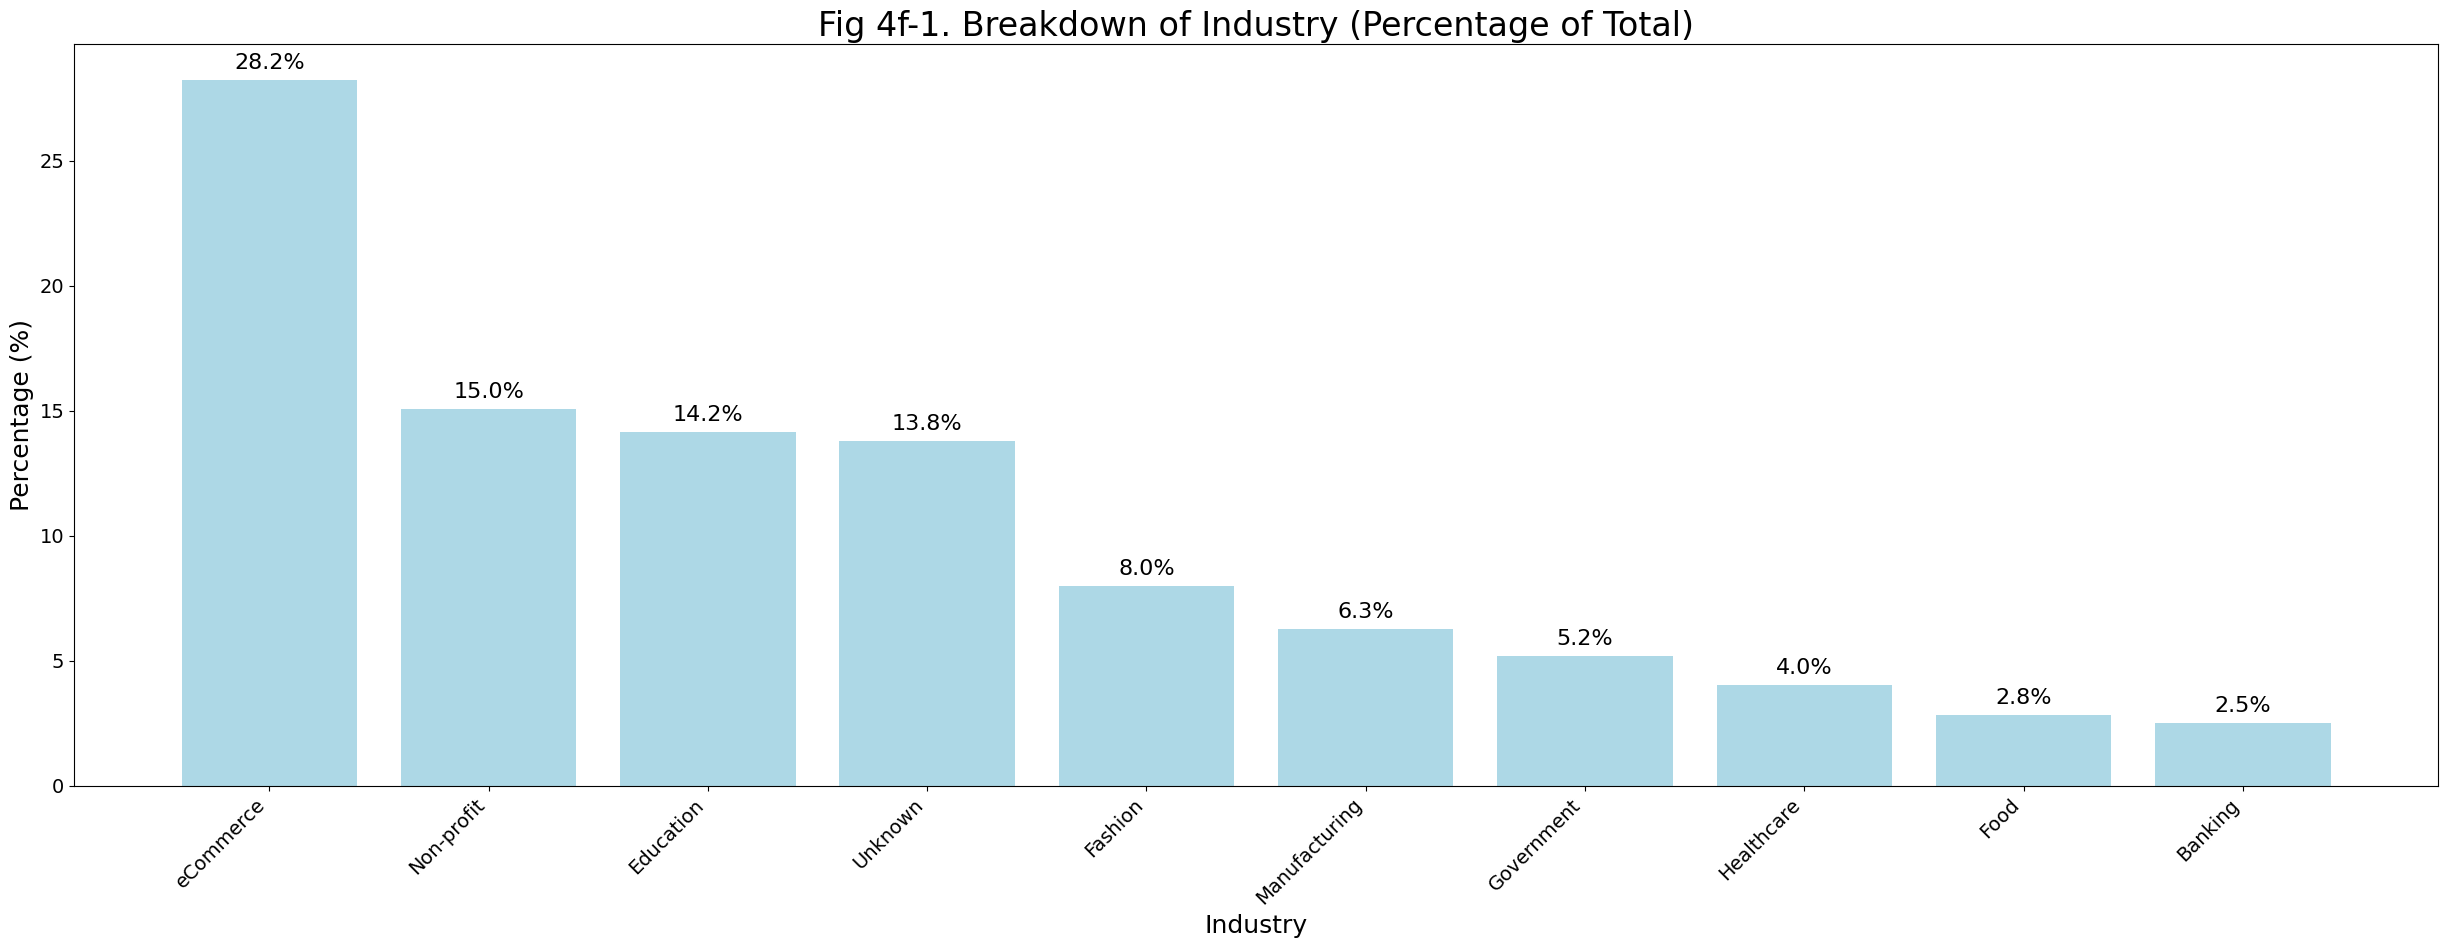

In [39]:
# Show Industry breakdown as percentage of total

plt.figure(figsize=(25,10))
plt.title("Fig 4f-1. Breakdown of Industry (Percentage of Total)", fontsize=24)
industry_counts = df.Industry.value_counts(normalize=True) * 100
bars = plt.bar(industry_counts.index, industry_counts.values, color='lightblue')
plt.ylabel('Percentage (%)', fontsize=18)
plt.xlabel('Industry', fontsize=18)
plt.xticks(rotation=45, ha='right', fontsize=14)
plt.yticks(fontsize=14)

# Add percentage labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + max(industry_counts.values)*0.01, f"{yval:.1f}%", ha='center', va='bottom', fontsize=16)

plt.tight_layout()
plt.show()

**Observations**
- The highest-represented industry type on the list (28%) is eCommerce, though a relatively high percentage (14%) are of unknown industries.

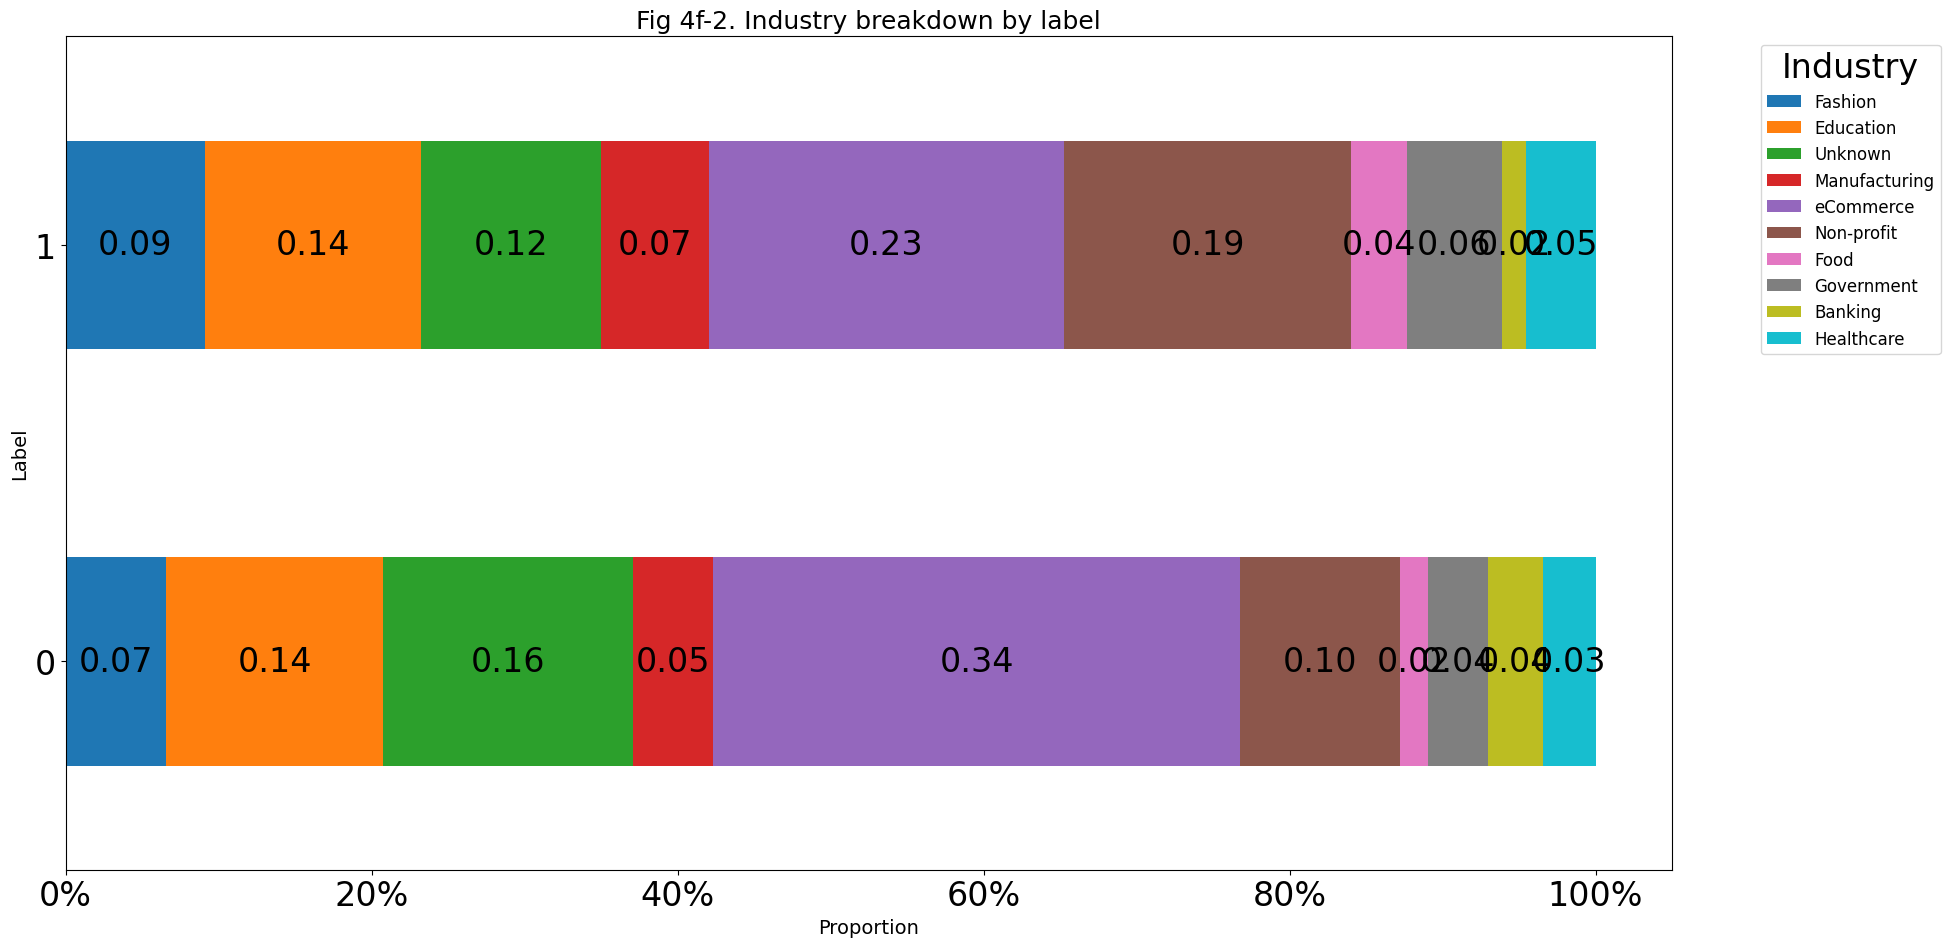

In [40]:
# Relationship between Industry and label (Horizontal Bar Chart)

df_4f1 = reformat_df(df, "label", "Industry", label_order = df.Industry.unique())
ax_4f1 = df_4f1.plot(kind='barh', stacked=True, figsize=(20, 10))
plt.title('Fig 4f-2. Industry breakdown by label', fontsize=18)
plt.ylabel('Label', fontsize=14)
plt.xlabel('Proportion', fontsize=14)
plt.gca().xaxis.set_major_formatter(lambda x, _: f'{x * 100:.0f}%')
plt.legend(title='Industry', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)

for c in ax_4f1.containers:
    ax_4f1.bar_label(c, label_type='center', fmt='%.2f')

plt.tight_layout()
plt.show()

In [41]:
# Feature Diagnostic on Industry and label
summary, detail = feature_diagnostic(df, "label", "Industry")

for val in summary:
    print("\033[1m" + val + "\033[0m", ": ", summary[val])

detail.sort_values(by = ["class", "lift",], ascending = False)

feature :  Industry
total_n :  10500
all_above_min_expected :  True
n_categories :  10
n_categories_used :  10
kept_categories :  ['Banking' 'Education' 'Fashion' 'Food' 'Government' 'Healthcare'
 'Manufacturing' 'Non-profit' 'Unknown' 'eCommerce']
unkept_categories :  []
n_classes :  2
chisq_p_value :  4.022585115410773e-83
cramers_v :  0.1980535647796761
base_rate_tracker :  False
categories_outside_lift_tol :  Banking, Fashion, Food, Government, Healthcare, Manufacturing, Non-profit, Unknown, eCommerce
frac_categories_outside_lift_tol :  0.9
max_category_l1_dist :  0.3886406926406926
note :  


,category,class,count,p_y_given_cat,base_p,lift,lift_dev_from_baseline,n
7,Food,1,209,0.71,0.55,1.28,0.28,296
15,Non-profit,1,1085,0.69,0.55,1.25,0.25,1580
9,Government,1,359,0.66,0.55,1.20,0.20,543
5,Fashion,1,528,0.63,0.55,1.14,0.14,839
13,Manufacturing,1,409,0.62,0.55,1.13,0.13,658
11,Healthcare,1,261,0.62,0.55,1.12,0.12,423
3,Education,1,816,0.55,0.55,1.00,0.00,1486
17,Unknown,1,677,0.47,0.55,0.85,0.15,1446
19,eCommerce,1,1341,0.45,0.55,0.82,0.18,2965
1,Banking,1,94,0.36,0.55,0.65,0.35,264


**Observations**
- Figure 4f-2, along with the results of the diagnostic, show that the distribution of malicious and benign sites varies meaningfully by industry, with cramers v of 0.19 showing a moderately strong association. 

Notably, sectors such as Banking, Food, and Non-Profit showed the most variation between malicious and benign sites, suggesting that certain industry types can serve as robust predictors for the label. 
- Most prevalent Industry types for malicious sites: banking, unknown, e-commerce - much higher prevalence in the malicious site distribution than in benign
- Most prevalent Industry types for benign sites: food, non-profit, government - much lower prevalence in malicious site distribution than in benign



### 4g. Impact of Hosting Provider on Label



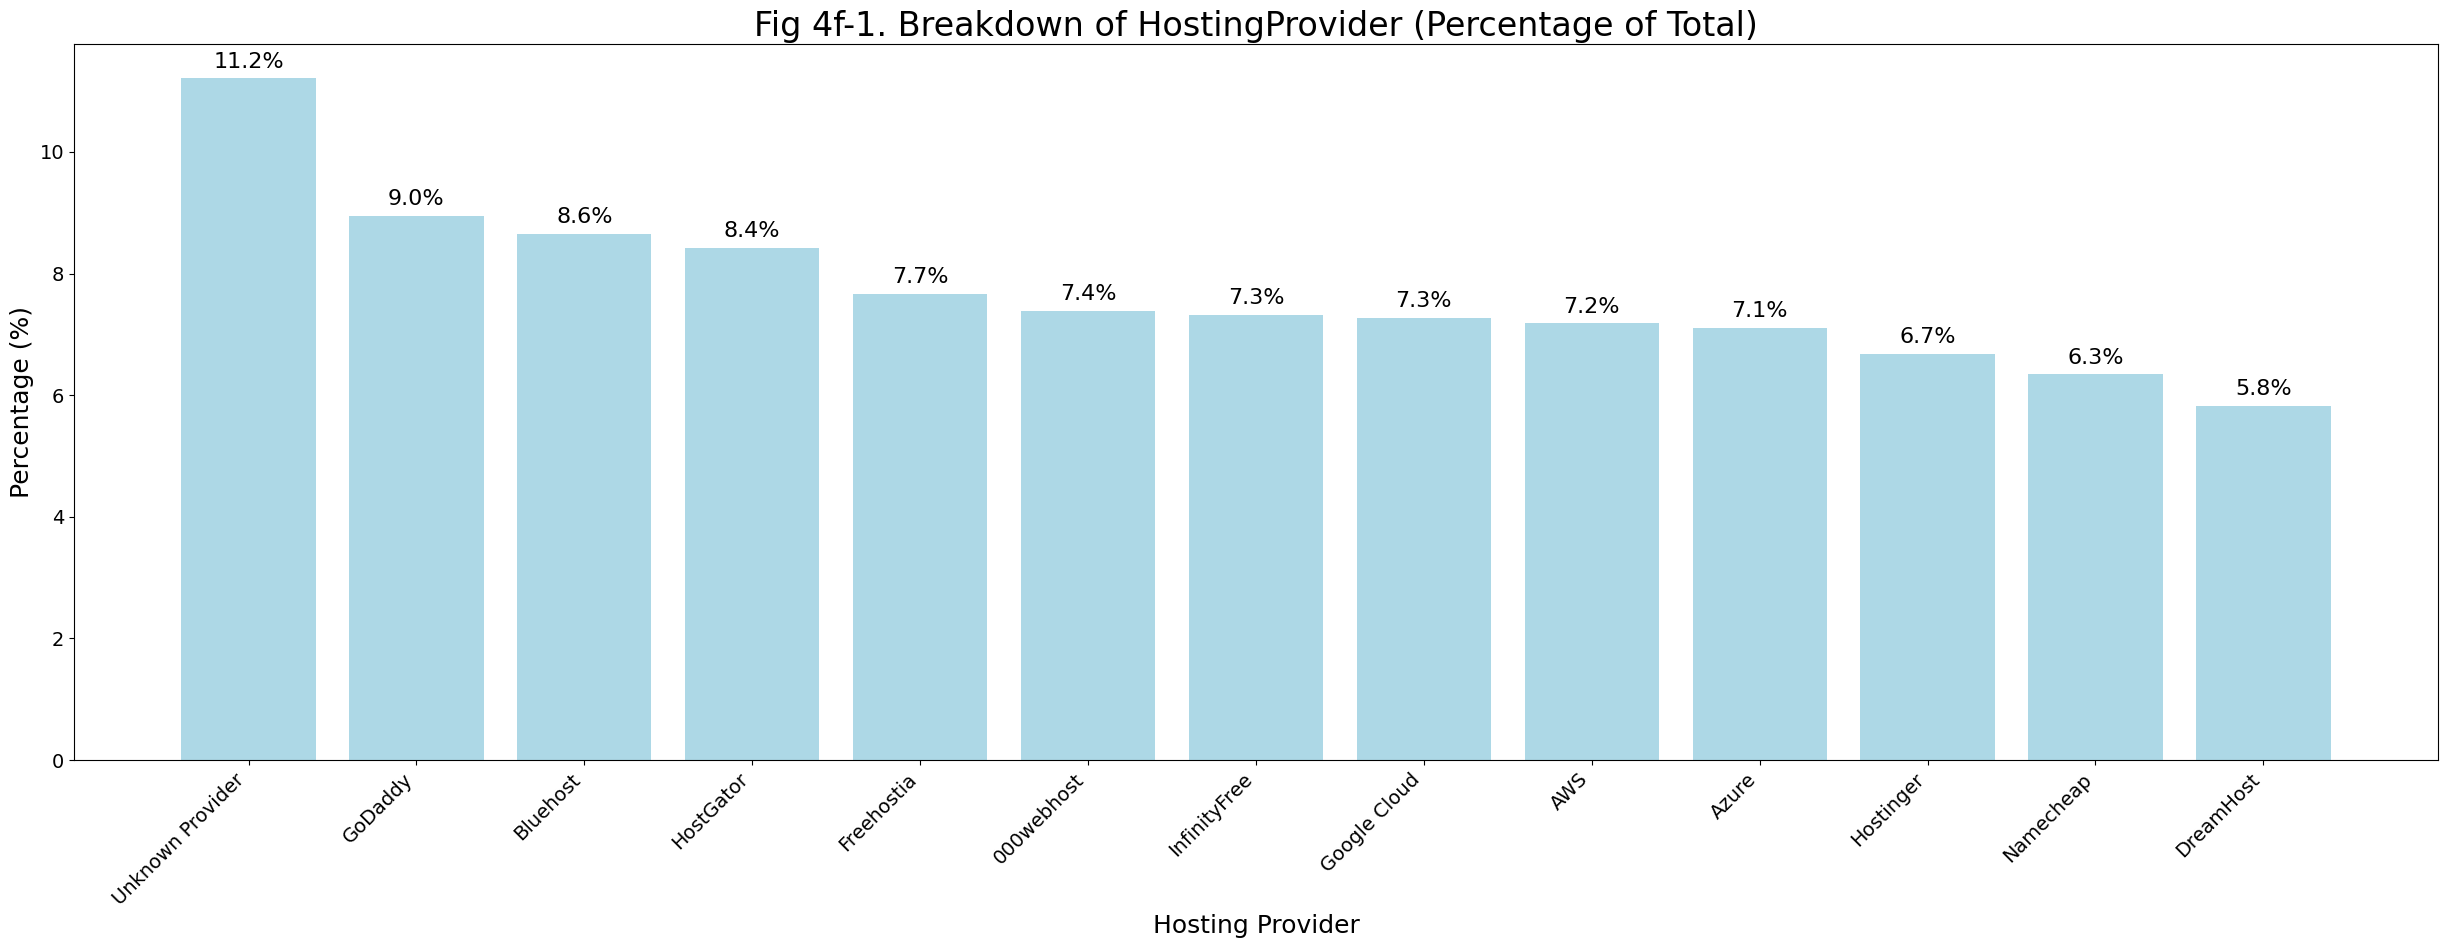

In [42]:
# Show HostingProvider breakdown as percentage of total

plt.figure(figsize=(25,10))
plt.title("Fig 4f-1. Breakdown of HostingProvider (Percentage of Total)", fontsize=24)
hosting_provider_counts = df.HostingProvider.value_counts(normalize=True) * 100
bars = plt.bar(hosting_provider_counts.index, hosting_provider_counts.values, color='lightblue')
plt.ylabel('Percentage (%)', fontsize=18)
plt.xlabel('Hosting Provider', fontsize=18)
plt.xticks(rotation=45, ha='right', fontsize=14)
plt.yticks(fontsize=14)

# Add percentage labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + max(hosting_provider_counts.values)*0.01, f"{yval:.1f}%", ha='center', va='bottom', fontsize=16)

plt.tight_layout()
plt.show()

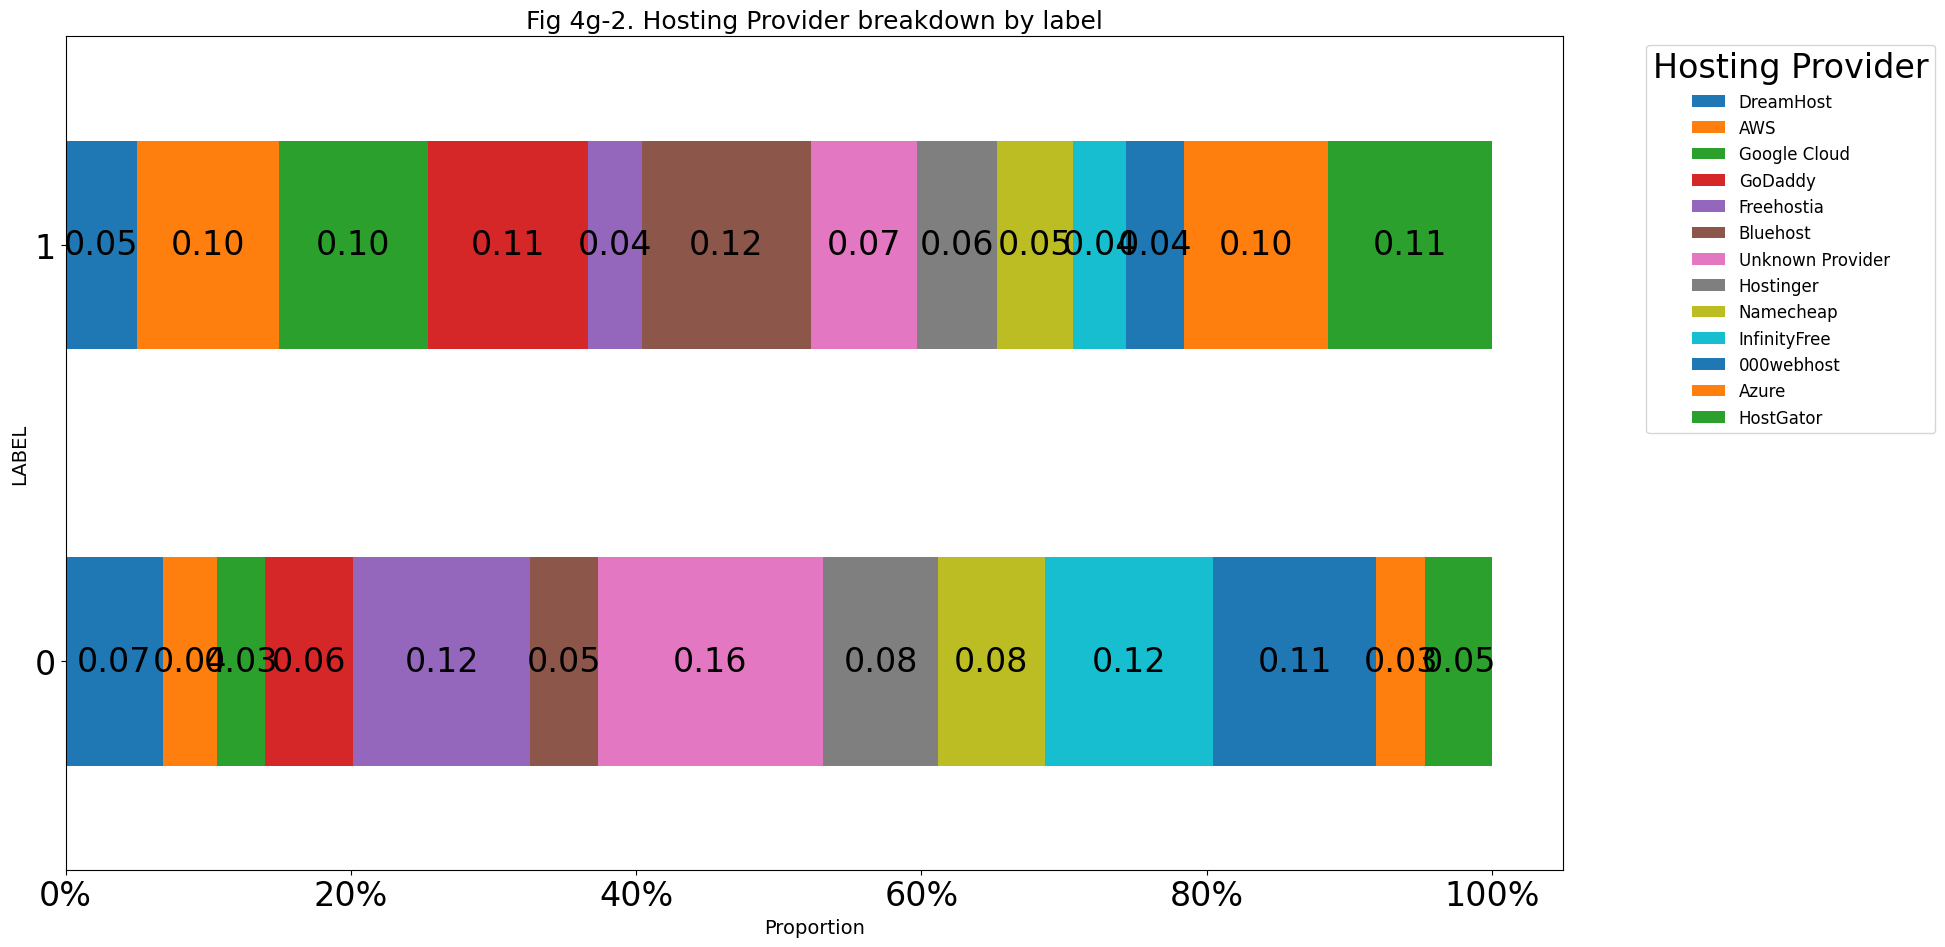

In [43]:
# Relationship between Hosting Provider and label (Horizontal Bar Chart)

df_4g1 = reformat_df(df, "label", "HostingProvider", label_order = df.HostingProvider.unique())
ax_4g1 = df_4g1.plot(kind='barh', stacked=True, figsize=(20, 10))
plt.title('Fig 4g-2. Hosting Provider breakdown by label', fontsize=18)
plt.ylabel('LABEL', fontsize=14)
plt.xlabel('Proportion', fontsize=14)
plt.gca().xaxis.set_major_formatter(lambda x, _: f'{x * 100:.0f}%')
plt.legend(title='Hosting Provider', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)

for c in ax_4g1.containers:
    ax_4g1.bar_label(c, label_type='center', fmt='%.2f')

plt.tight_layout()
plt.show()

In [44]:
# Feature Diagnostic on HostingProvider and label
summary, detail = feature_diagnostic(df, "label", "HostingProvider")

for val in summary:
    print("\033[1m" + val + "\033[0m", ": ", summary[val])

detail.sort_values(by = ["class", "lift",], ascending = False)

feature :  HostingProvider
total_n :  10500
all_above_min_expected :  True
n_categories :  13
n_categories_used :  13
kept_categories :  ['000webhost' 'AWS' 'Azure' 'Bluehost' 'DreamHost' 'Freehostia' 'GoDaddy'
 'Google Cloud' 'HostGator' 'Hostinger' 'InfinityFree' 'Namecheap'
 'Unknown Provider']
unkept_categories :  []
n_classes :  2
chisq_p_value :  0.0
cramers_v :  0.4069773428537409
base_rate_tracker :  False
categories_outside_lift_tol :  000webhost, AWS, Azure, Bluehost, DreamHost, Freehostia, GoDaddy, Google Cloud, HostGator, Hostinger, InfinityFree, Namecheap, Unknown Provider
frac_categories_outside_lift_tol :  1.0
max_category_l1_dist :  0.5516935817805384
note :  


,category,class,count,p_y_given_cat,base_p,lift,lift_dev_from_baseline,n
15,Google Cloud,1,605,0.79,0.55,1.44,0.44,763
5,Azure,1,585,0.78,0.55,1.42,0.42,746
3,AWS,1,574,0.76,0.55,1.38,0.38,754
7,Bluehost,1,684,0.75,0.55,1.37,0.37,908
17,HostGator,1,664,0.75,0.55,1.36,0.36,885
13,GoDaddy,1,646,0.69,0.55,1.25,0.25,940
9,DreamHost,1,290,0.47,0.55,0.86,0.14,611
23,Namecheap,1,311,0.47,0.55,0.85,0.15,666
19,Hostinger,1,322,0.46,0.55,0.83,0.17,701
25,Unknown Provider,1,430,0.37,0.55,0.66,0.34,1177


**Observations**
- Figure 4g-2, along with the results of the diagnostic, show that the distribution of malicious and benign sites varies meaningfully by hosting provider, with cramers v of 0.4 showing a remarkably strong association. 

Notably, there is a clear separation in the kinds of hosting providers that are most prevalent in malicious sites, compared to those that are more prevalent in benign sites. In particular:
- Most prevalent hosting providers for malicious sites: Freehostia, InfinityFree, 000webhost, unknown provider (based on the names, these seem to be smaller, free web host providers)
- Most prevalent hosting providers for benign sites: Google Cloud, Azure, AWS (reputable cloud servcie platform providers that charge for usage) 


### 4h-1: Analyses of Numerical Features on Activity Levels<a id='4-2'></a>
[Return to Part 4](#4)

In [45]:
summary = df[num_cols].describe()
summary

,LineOfCode,LargestLineLength,NoOfPopup,NoOfiFrame,NoOfImage,NoOfSelfRef,NoOfExternalRef,DomainAgeMonths
count,10500.00,10500.00,10500.00,10500.00,10500.00,10500.00,10500.00,10500.00
mean,1068.12,11197.96,0.23,1.67,326.45,68.54,51.15,33.17
std,5098.05,94168.98,5.70,5.02,30896.84,316.68,204.90,32.70
min,0.00,22.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,2.00,180.75,0.00,0.00,0.00,0.00,1.00,5.00
50%,271.00,1087.50,0.00,0.00,5.00,12.00,10.00,24.00
75%,1145.00,8047.00,0.00,1.00,25.00,87.00,55.00,52.00
max,418650.00,4336498.00,564.00,131.00,3166000.00,26596.00,12353.00,120.00


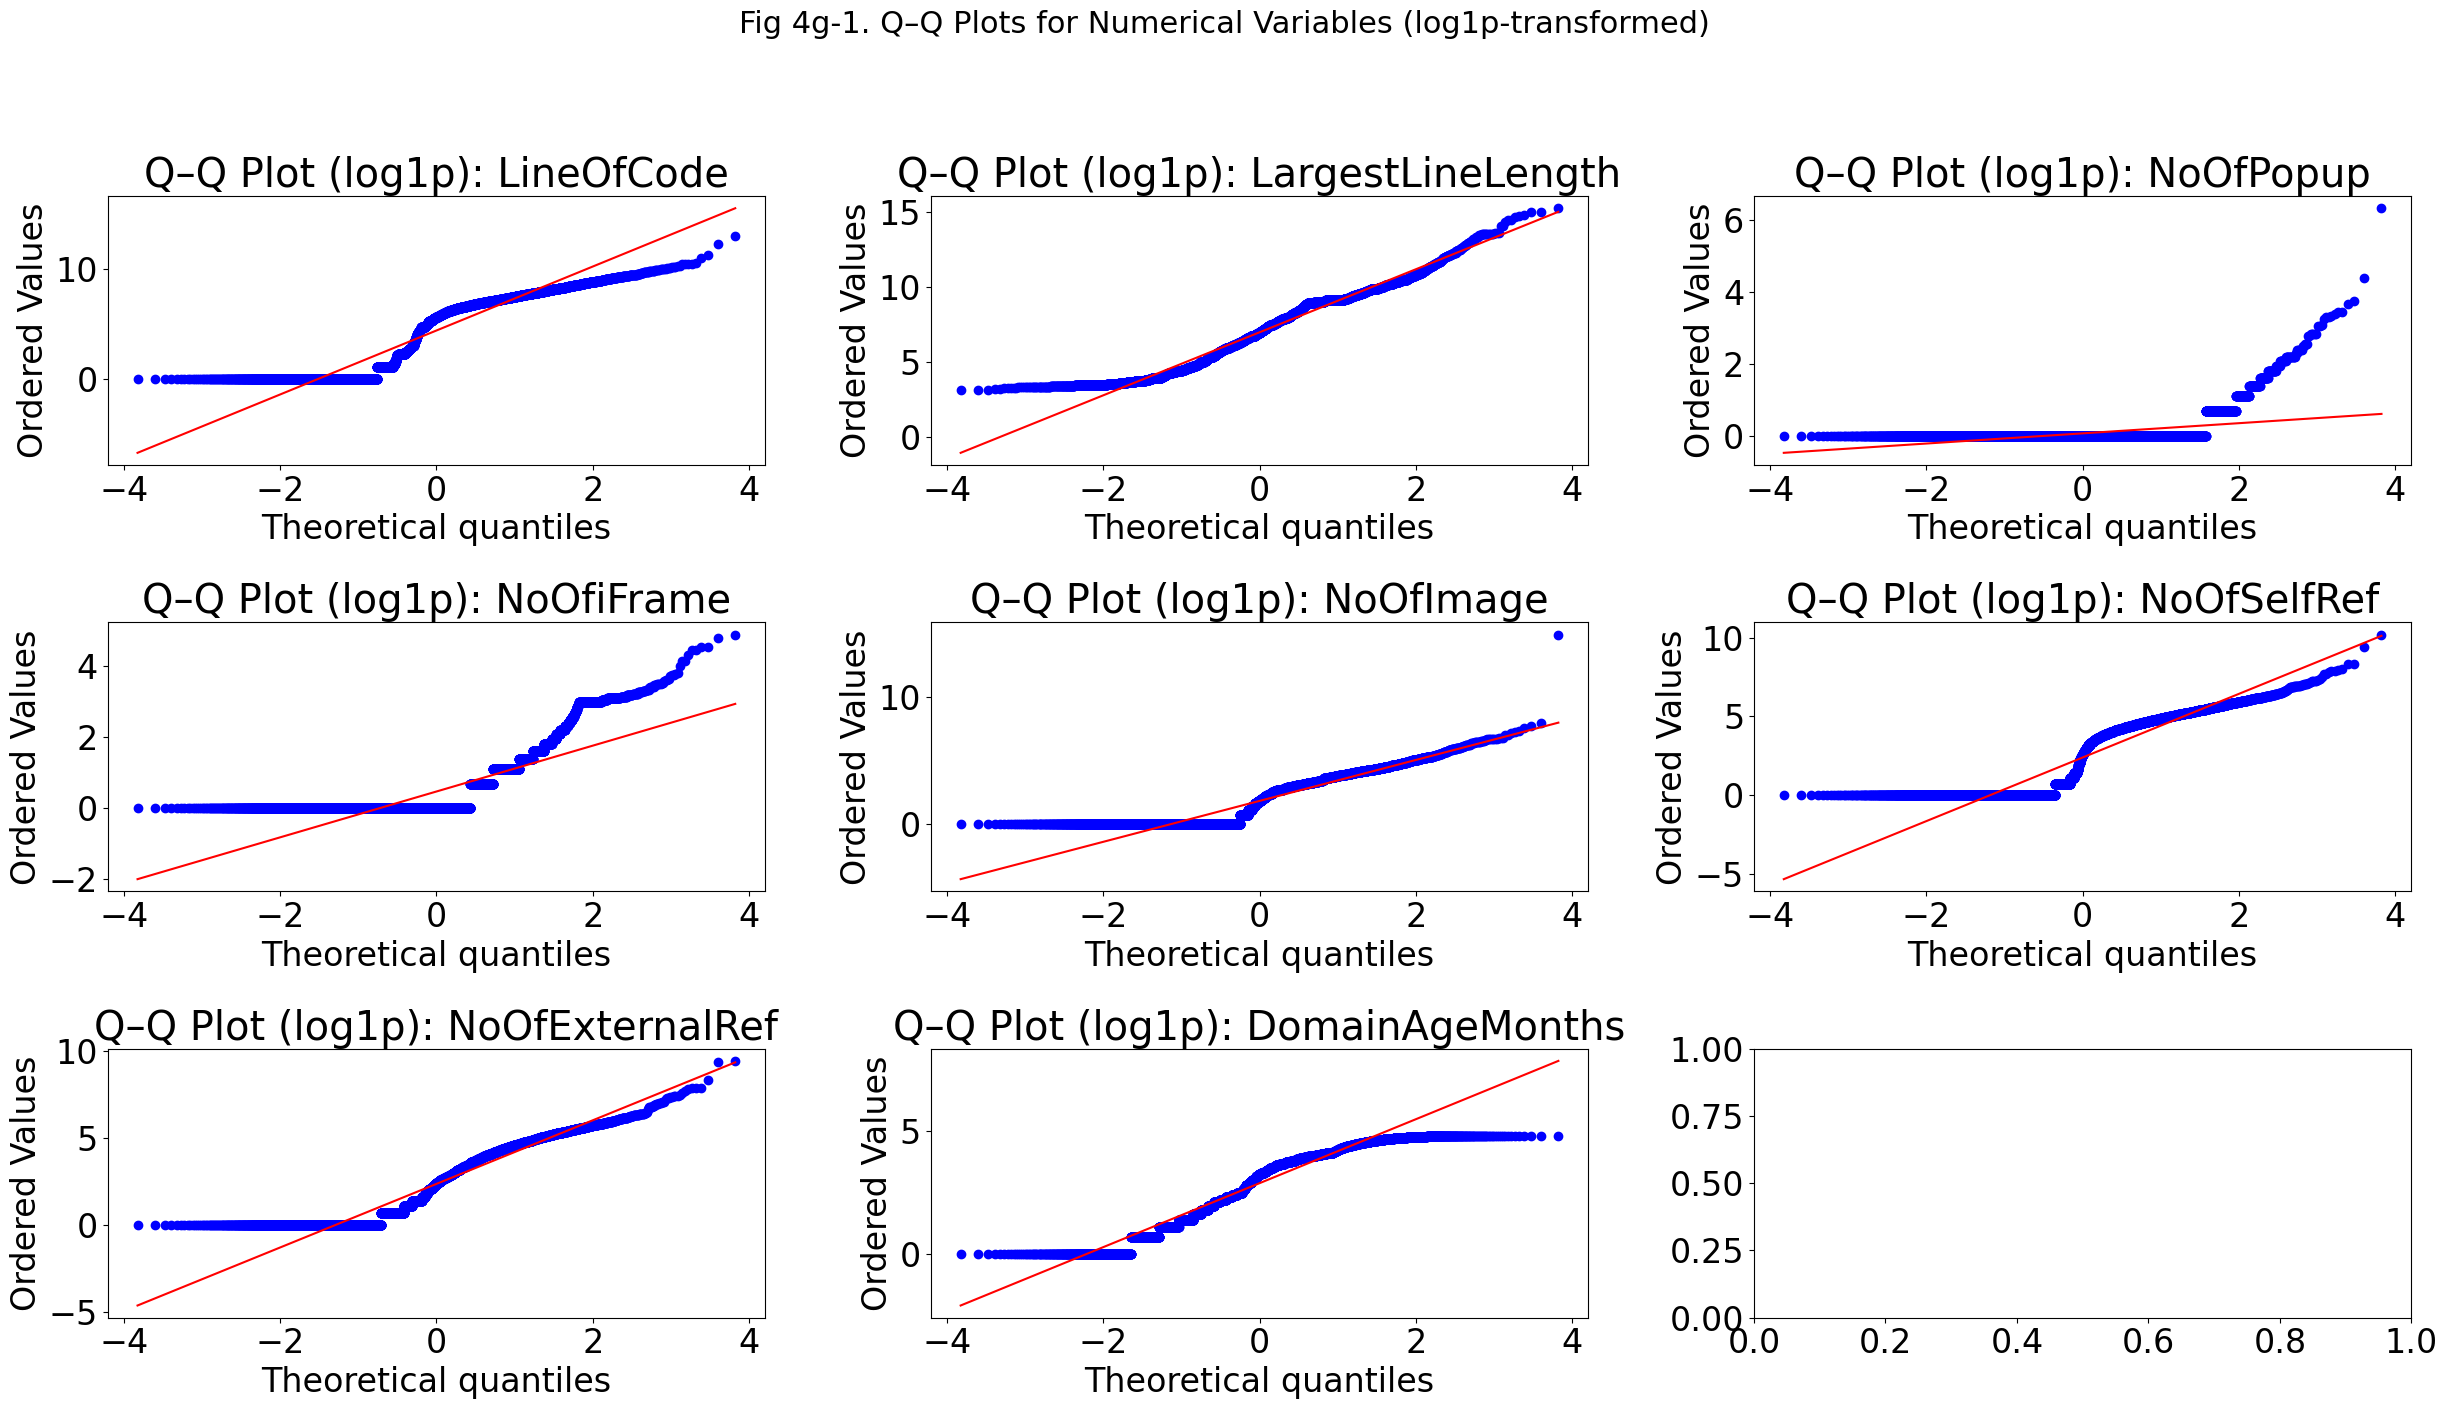

In [46]:
# Q-Q plot to discern normality of distribution

import scipy.stats as stats

fig, ax = plt.subplots(3, 3, figsize=(25, 15))
row = col = 0

for n, feat in enumerate(num_cols[:9]):  # guard if more than 9
    if (n % 3 == 0) and (n > 0):
        row += 1
        col = 0

    s = df[feat].dropna()

    # log-transform (safe for zeros)
    s_log = np.log1p(s)

    stats.probplot(s_log, dist="norm", plot=ax[row, col])
    ax[row, col].set_title(f"Q–Q Plot (log1p): {feat}")

    col += 1

plt.suptitle(
    "Fig 4g-1. Q–Q Plots for Numerical Variables (log1p-transformed)",
    fontsize=22
)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



**Observations**

- After taking lop1p transformations to reduce outlier impact on Q-Q plot visualization, we find that all of the numerical variable distributions are **not** normal or log-normal:
    - **LineOfCode**: The long tail of 0-values came from our imputation on NA values, but even the rest of the distribution is not normal.
    - **NoOfPopup**, **NoOfiFrame**, **NoOfImage**, **NoOfSelfRef**, **NoOfExternalRef** and even **DomainAgeMonths** are heavily weighted towards zeroes (i.e. 0 value is a clear mode)
    - The non-zero log1p-transformed portions of **NoOfImage**, **NoOfExternalRef** approach normal behaviour but demonstrate heavy- or light-tailed behavior

- This might signal that the presence of zeroes as opposed to non-zero values is a meaningful signal. We'll run the battery of categorical feature diagnostic tests on zero/non-zero coded versions of these features to see if there is a meaningful difference, before looking at tree-based models to investigate the relationship between the numeric values and the label. 

- The results of these Q-Q plot visualizations suggest the need for a bifurcated approach in engineering features for the model: to create categorical flags for zero/non-zero values, and incorporating magnitudes into the model where they have been shown to have significant impact.


In [47]:
num_cols_longtailzero = ["NoOfPopup", "NoOfiFrame", "NoOfImage", "NoOfSelfRef", "NoOfExternalRef", "DomainAgeMonths"]
lift_tol = 0.1

for col in num_cols_longtailzero:
    df[f"{col}IsZero"] = np.where(df[col] == 0, 1, 0)
    summary, detail = feature_diagnostic(df, "label", f"{col}IsZero", lift_tol = lift_tol)
    for cls in [0, 1]:
        for cat in [0, 1]:
            val = detail[(detail["category"] == cat) & (detail["class"] == cls)]["lift"].item()
            if val > 1 + lift_tol:
                print(f"{col} being {"zero" if cat == 1 else "non-zero"} is more prevalent amongst {"benign" if cls == 1 else "malicious"} sites.")
            elif val < 1 - lift_tol:
                print(f"{col} being {"zero" if cat == 1 else "non-zero"} is less prevalent amongst {"benign" if cls == 1 else "malicious"} sites.")
            else:
                print(f"{col} being {"zero" if cat == 1 else "non-zero"} is not significantly more prevalent amongst {"benign" if cls == 1 else "malicious"} sites.")
    print("--------------------------------")
                


NoOfPopup being non-zero is less prevalent amongst malicious sites.
NoOfPopup being zero is not significantly more prevalent amongst malicious sites.
NoOfPopup being non-zero is more prevalent amongst benign sites.
NoOfPopup being zero is not significantly more prevalent amongst benign sites.
--------------------------------
NoOfiFrame being non-zero is less prevalent amongst malicious sites.
NoOfiFrame being zero is more prevalent amongst malicious sites.
NoOfiFrame being non-zero is more prevalent amongst benign sites.
NoOfiFrame being zero is less prevalent amongst benign sites.
--------------------------------
NoOfImage being non-zero is less prevalent amongst malicious sites.
NoOfImage being zero is more prevalent amongst malicious sites.
NoOfImage being non-zero is more prevalent amongst benign sites.
NoOfImage being zero is less prevalent amongst benign sites.
--------------------------------
NoOfSelfRef being non-zero is less prevalent amongst malicious sites.
NoOfSelfRef being

In [54]:
#Since there are some invalid values of NoOfImages, run the above on the subset as well

summary, detail = feature_diagnostic(df, "label", "NoOfImagesInvalid", lift_tol = lift_tol)

for val in summary:
    print(val, ": ", summary[val])

print(detail)

feature :  NoOfImagesInvalid
total_n :  10500
all_above_min_expected :  True
n_categories :  2
n_categories_used :  2
kept_categories :  [0 1]
unkept_categories :  []
n_classes :  2
chisq_p_value :  9.382578057968866e-26
cramers_v :  0.10239331163986874
base_rate_tracker :  False
categories_outside_lift_tol :  1
frac_categories_outside_lift_tol :  0.5
max_category_l1_dist :  0.5278853100922066
note :  
   category  class  count  p_y_given_cat  base_p  lift  \
0         0      0   4651           0.46    0.45  1.02   
1         0      1   5472           0.54    0.55  0.98   
2         1      0     70           0.19    0.45  0.41   
3         1      1    307           0.81    0.55  1.48   

   lift_dev_from_baseline      n  
0                    0.02  10123  
1                    0.02  10123  
2                    0.59    377  
3                    0.48    377  


In [55]:
#Since there are some null values of LineOfCode, run the above on the subset as well

summary, detail = feature_diagnostic(df, "label", "LineOfCodeIsMissing", lift_tol = lift_tol)

for val in summary:
    print(val, ": ", summary[val])

print(detail)

feature :  LineOfCodeIsMissing
total_n :  10500
all_above_min_expected :  True
n_categories :  2
n_categories_used :  2
kept_categories :  [0 1]
unkept_categories :  []
n_classes :  2
chisq_p_value :  0.0
cramers_v :  0.5949209440499508
base_rate_tracker :  False
categories_outside_lift_tol :  0, 1
frac_categories_outside_lift_tol :  1.0
max_category_l1_dist :  1.1007619047619048
note :  
   category  class  count  p_y_given_cat  base_p  lift  \
0         0      0   2366           0.29    0.45  0.65   
1         0      1   5779           0.71    0.55  1.29   
2         1      0   2355           1.00    0.45  2.22   
3         1      1      0           0.00    0.55  0.00   

   lift_dev_from_baseline     n  
0                    0.35  8145  
1                    0.29  8145  
2                    1.22  2355  
3                    1.00  2355  


**Observations**

- Based on the above results, we see a general trend: amongst benign websites, there is a greater of sites that contain **popups, iFrames, images, and self- and external references**, compared to both malicious sites and the general population. 
- Amongst malicious websites, there is a greater prevalence of sites having **no iFrames, images, or self/external references** relative to baseline. That said, a site having zero popups is not strongly associated with whether a website is malicious or not. For invalid/negative values of number of images, prevalence of benign sites was much higher. 
- All sites that had no data on number of lines were malicious, which could be the impact of the synthetic nature of the data or some sort of label leakage. Sites with valid LineOfCode data, on the other hand, were more likely than not to be benign, above the base rate. 
- Sites that are zero months old are more prevalent amongst malicious sites, and less prevalent in benign sites. But sites being at least a month old are not strongly associated with a site being either benign or malicious. 

### 4h-2 - Visualizing and Characterizing Relationships between Non-Zero Components of Numeric Variables and Label

Given the clear impact of the zero/non-zero split of many numeric variables on the class distribution, it may be instructive to add categorical features for *feature = 0* to capture these signals more cleanly. However, we also want to investigate the non-zero components of the features to look at the direction and monotonicity of their relationship with the label. 

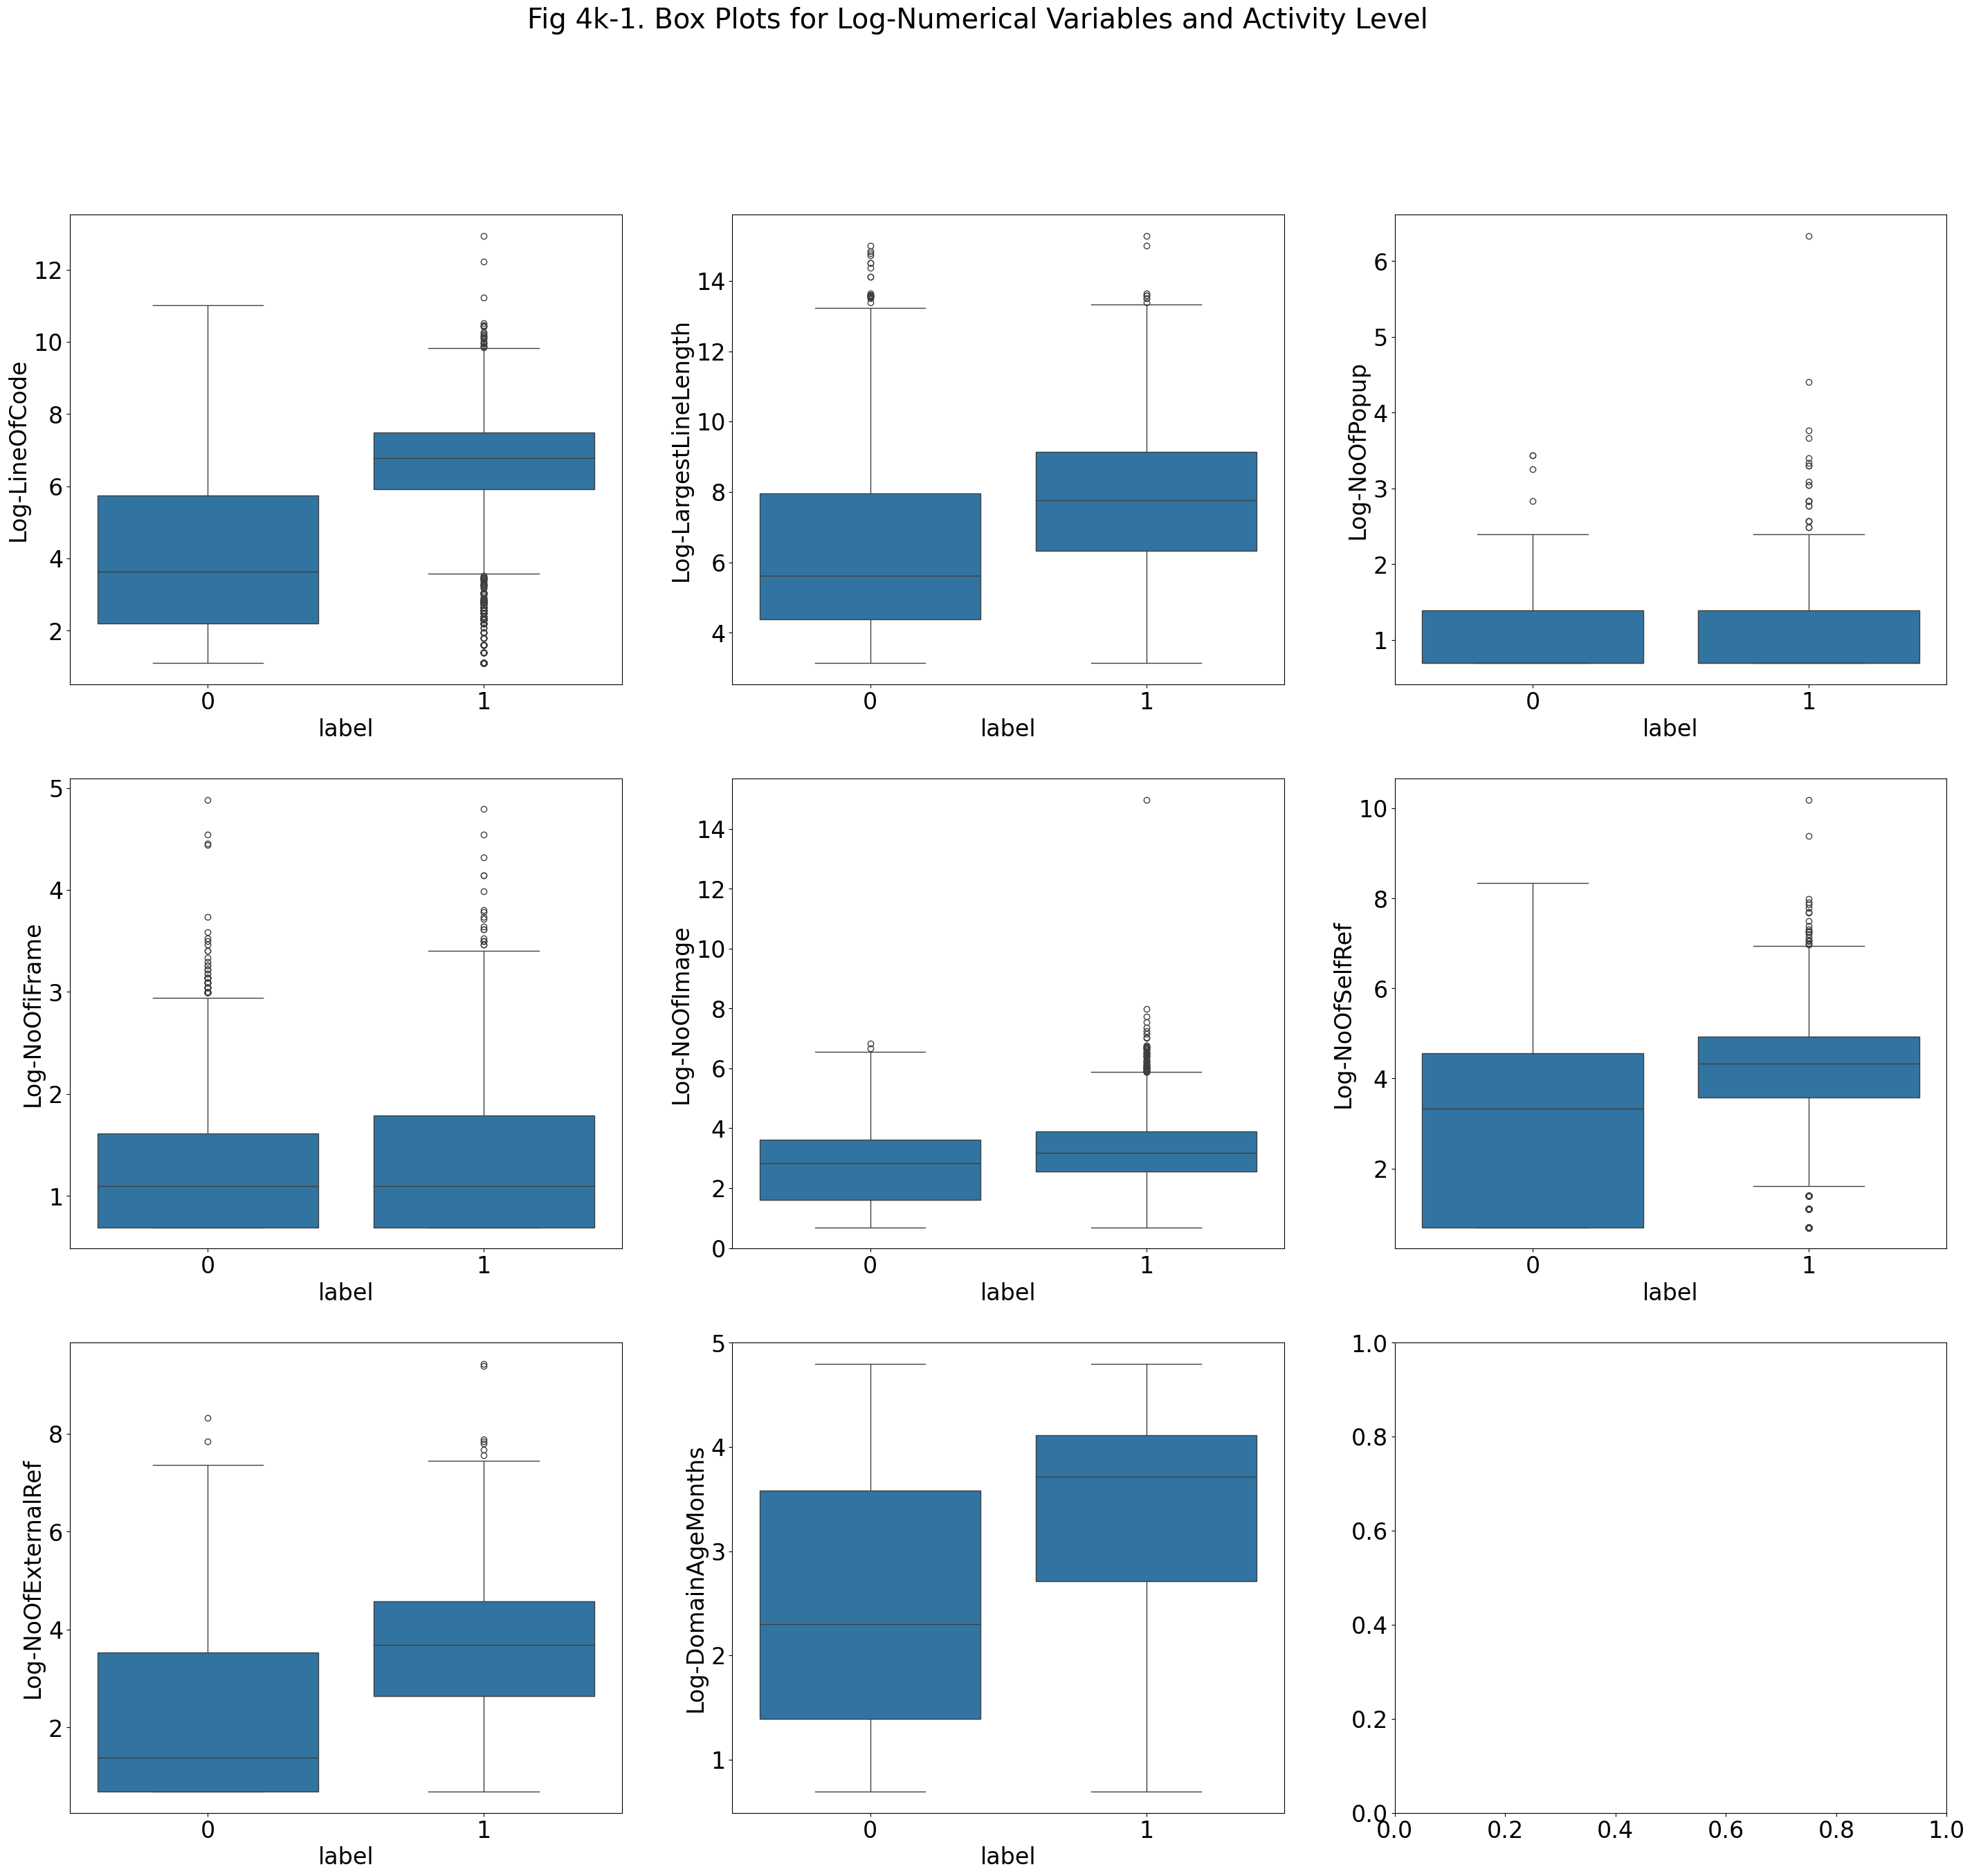

In [48]:
# Boxplots 

fig, ax = plt.subplots(3, 3, figsize=(35, 30))
row = col = 0
for n, i in enumerate(num_cols):
    if (n % 3 == 0) and (n > 0):
        row += 1
        col = 0
    df_nonzero = df[df[i] != 0].copy()
    df_nonzero[i] = np.log1p(df_nonzero[i])
    sns.boxplot(x="label", y=i, data=df_nonzero, ax=ax[row, col])
    ax[row, col].set_ylabel(f"Log-{i}")
    col += 1
    
plt.suptitle("Fig 4k-1. Box Plots for Log-Numerical Variables and Activity Level")
plt.show()

In [51]:
# Run ANOVA test and Spearman Correlation to check for significant association between activity level and numeric values

results = []

for col in num_cols:
    df_nonzero = df[df[col] != 0].copy()
    f_stat, p = anova(df_nonzero, "label", col)
    pearson_score = df_nonzero[col].corr(df_nonzero["label"], method='pearson')
    spearman_score = df_nonzero[col].corr(df_nonzero["label"], method='spearman')
    result = {
        "Column": col,
        "ANOVA p-value": p,
        "ANOVA significant (p<0.05)": p < 0.05,
        "Pearson r": pearson_score,
        "Spearman r": spearman_score,
    }
    results.append(result)

results_df = pd.DataFrame(results).set_index("Column")
display(results_df)

,ANOVA p-value,ANOVA significant (p<0.05),Pearson r,Spearman r
Column,,,,
LineOfCode,0.00,True,0.09,0.45
LargestLineLength,0.02,True,-0.02,0.33
NoOfPopup,0.58,False,0.02,-0.04
NoOfiFrame,0.70,False,-0.01,0.03
NoOfImage,0.55,False,0.01,0.17
NoOfSelfRef,0.00,True,0.06,0.27
NoOfExternalRef,0.00,True,0.09,0.39
DomainAgeMonths,0.00,True,0.32,0.36


Based on the visual inspection of the log-adjusted boxplots of the non-zero components of the numerical variables, as well as the results of the ANOVA and correlation tests, the following observations can be made:

**LineOfCode**. The number of lines of code is significantly (p=0) different between classes, with more lines of code being more prevalent in benign websites. This relationship is not linear but is highly monotonic. All sites that had null values of this feature were labeled as malicious. 

**LargestLineLength**. The mean largest line length is significantly (p=0.02) different between classes. Sites with longer largest code lengths are more prevalent amongst benign sites. This relationship is not linear but also highly monotonic. 

**NoOfPopup**. A non-zero feature is more prevalent amongst benign sites, though the magnitude does not seem to matter, given the non-significant results of the ANOVA and correlation tests. This feature being zero communicates no information about the site's class. 

**NoOfiFrame**. A non-zero feature is more prevalent amongst benign sites, though the magnitude does not seem to matter, given the non-significant results of the ANOVA and correlation tests. This feature being zero is more prevalent amongst malicious sites. 

**NoOfImage**. Similary to **NoOfiFrame**, a non-zero feature is more prevalent amongst benign sites, though the magnitude does not seem to matter, given the non-significant results of the ANOVA and correlation tests. This feature being zero is more prevalent amongst malicious sites. The feature being invalid (i.e. negative zero) seems to be much more prevalent in benign sites.

**NoOfSelfRef**. Amongst the non-zero values of this feature, the mean number of self references in a site is significantly (p=0.00) different between classes. Sites with self-references are more prevalent amongst benign sites. This relationship is not linear but fairly monotonic. Zero values of this feature are more prevalent with malicious sites, and less with benign sites.  

**NoOfExternalRef**. Similar to **NoOfSelfRef**, amongst the non-zero values of this feature, the mean number of external references in a site is significantly (p=0.00) different between classes. Sites with self-references are more prevalent amongst benign sites. This relationship is not linear but fairly monotonic. Zero values of this feature are more prevalent with malicious sites, and less with benign sites.  
 
**DomainAgeMonths**. This feature being zero was more prevalent in malicious sites, but merely being non-zero was not informative. That said, there is a significant positive association between site age and a site being benign, based on the tests. The relationship is modestly linear and monotonic. 


In [50]:
dftest = df.copy()

dftest["NoOfPopup_iszero"] = np.where(dftest["NoOfPopup"] == 0, 1, 0)
summary, detail = feature_diagnostic(dftest, "label", "NoOfPopup_iszero", lift_tol = 0.1)

for i in summary:    print(i, ": ", summary[i])
print(detail)


feature :  NoOfPopup_iszero
total_n :  10500
all_above_min_expected :  True
n_categories :  2
n_categories_used :  2
kept_categories :  [0 1]
unkept_categories :  []
n_classes :  2
chisq_p_value :  1.5370575199572318e-33
cramers_v :  0.11778288564220535
base_rate_tracker :  False
categories_outside_lift_tol :  0
frac_categories_outside_lift_tol :  0.5
max_category_l1_dist :  0.4734955209806695
note :  
   category  class  count  p_y_given_cat  base_p  lift  \
0         0      0    129           0.21    0.45  0.47   
1         0      1    477           0.79    0.55  1.43   
2         1      0   4592           0.46    0.45  1.03   
3         1      1   5302           0.54    0.55  0.97   

   lift_dev_from_baseline     n  
0                    0.53   606  
1                    0.43   606  
2                    0.03  9894  
3                    0.03  9894  


## 5. Conclusions <a id='5'></a>
[Return to Table of Contents](#0)

Based on the EDA of the provided dataset, we can make some preliminary conclusions and assumptions:

1. The data is likely a non-random subsample of readings, given that the class proportions between benign and malicious sites are roughly equal. This would not be robust with real world data to run validation on. Numerical data is non-Gaussian, with significant incidence of structural zeroes and extreme outliers that are consistent with expected behaviours of benign and malicious sites.  

2. In terms of dataset quality and cleaning, we will take the following steps when building the data cleaning pipeline for the model:

    - Outliers and Unusual Values
        - **NoOfPopup**, **NoOfImage**, **NoOfIFrame**. These have a number of outlier values. Given that section 4h-2 established that magnitude was not strongly connotative of whether a site was benign or not, we will likely ignore these values in favor of transforming the values into categorical zero/non-zero values later on. 
        - **NoOfImage**. Given that the invalidity of the image count contributed significant information to variation in class distribution, we will not impute values to mask its effect, but instead turn this into an additional categorical flag for NoOfImage at the feature engineering stage. 
    - Missing values
        - **LineOfCode**. LineOfCode has a significant proportion of missing values that are not MCAR with respect to the label. Thus, we will impute median and create a categorical missingness indicator for the data down the line. 
    - Inconsistent Schema
        - **Industry**, **HostingProvider**. Strip whitespace from text-heavy values. No other irregularities were observed in the given dataset, so that is sufficient for now. 

2. Based on EDA of categorical and numerical variables, we can establish some baseline feature importances for the extant and engineered features in terms of the impact on class distribution:

# # # 
# # # | Categorical Variable   | Impact of Feature in Predicting Malicious Site                                                 | Strength of Association     | Verdict                      |
# # # |------------------------|------------------------------------------------------------------------------------|----------------------------|------------------------------|
# # # | NoOfURLRedirect        | Weakly ↑ probability with presence of redirects                                    | Weak                       | Base rate tracker at best    |
# # # | NoOfSelfRedirect       | ↑ probability with presence, but absence not indicative                                        | Moderate                   | Potentially useful           |
# # # | Robots                 | ↓ probability with presence, ↑ with absence                                                        | Moderate                   | Keep                         |
# # # | IsResponsive           | ↓ probability with presence, ↑ with absence                                                        | Moderate                   | Keep                         |
# # # | Industry               | Certain categories notably ↑ probability, others ↓                                 | Moderate-to-strong         | Feature engineering needed   |
# # # | HostingProvider        | Certain providers notably ↑ probability, others ↓                                  | Moderate-to-strong         | Feature engineering needed   |
# 

4. Based on the analysis of the various features, we will adopt the following feature engineering steps: 

    - **Numeric Features**. All numeric variables will be kept in the initial model and standardized for flexibility to deal with different models.
    - **Categorical Features**. All categorical features will be kept in the initial model and encoded accordingly. The model will have a feature importance step that will be used to ascertain if features like **HVAC Operation Mode** and **Ambient Light Levels**, which were found not to have signficiant association with the target, will be kept. 

        - **CO Gas Sensor Readings**, **Ambient Light Levels**: As clearly ordinal categorical features, these will be mapped to numerical equivalents.
        - **HVAC Operation Mode**, **Time of Day:**: As categorical features without clear-cut ordinality, these will be one-hot encoded. 
        - **Missingness Indicators** Missingness indicators were generated for columns where imputation was necessary. Since these are already binary, no further feature engineering will be done, though they may be selected out at the feature importance stage. 

    - **Target Variable**. As **activity_levels** appars to an ordinal we will encode with numbers.

    ---